## Descripción del proyecto

📊 **Proyecto: Predicción de Churn en Clientes de Telecomunicaciones**

🎯 **Objetivo**

En este proyecto aplicaremos técnicas de **Machine Learning supervisado** para resolver un problema de **clasificación binaria**:  
**Predecir si un cliente de una compañía de telecomunicaciones abandonará (Churn) o no, en función de sus características y comportamiento.**

El objetivo es construir un modelo que permita a la empresa identificar a los clientes con mayor riesgo de cancelar sus servicios, para tomar acciones preventivas como ofrecer promociones o mejoras en el servicio.

---

📂 **Dataset**

El dataset contiene información sobre **7,184 clientes** de una compañía de telecomunicaciones, con las siguientes características:
- **Datos demográficos:** género, número de hijos, senioridad.
- **Detalles del servicio:** tipo de contrato, servicios contratados (internet, streaming, etc.), método de pago.
- **Comportamiento de uso y facturación:** cargos mensuales, cargos totales, número de quejas.
- **Variable objetivo (`Churn`):** indica si el cliente se dio de baja (`Yes`) o continúa con la empresa (`No`).

---

🚀 **Pasos del proyecto**
1. **Exploración de datos (EDA):**
   - Entender la estructura del dataset y la distribución de las variables.
   - Identificar valores faltantes, datos inconsistentes y variables irrelevantes.
2. **Preprocesamiento:**
   - Limpieza de datos: manejo de valores nulos, codificación de variables categóricas, conversión de tipos de datos.
   - Escalado de variables numéricas (si es necesario).
3. **Ingeniería de características:**
   - Crear nuevas variables relevantes (ej. número total de servicios contratados, bucket de tenure).
   - Eliminar columnas poco útiles (ej. IDs únicos).
4. **Entrenamiento del modelo:**
   - Seleccionar un algoritmo de clasificación (Logistic Regression, Random Forest, etc.).
   - Dividir el dataset en conjuntos de entrenamiento y prueba.
5. **Evaluación del modelo:**
   - Calcular métricas como precisión, recall, F1-score, y la matriz de confusión.
   - Analizar la importancia de las variables.
6. **Interpretación y recomendaciones:**
   - ¿Qué factores contribuyen más al churn?
   - ¿Cómo podría la empresa usar estos insights para reducir la tasa de abandono?

---

📌 **Resultado esperado**

Un modelo de Machine Learning capaz de predecir con alta precisión qué clientes están en riesgo de churn, junto con un análisis de los factores que más influyen en esa decisión.

---

🧠 **Preguntas para reflexionar**
- ¿Qué variables parecen ser más predictivas del churn?
- ¿Cómo tratarías las columnas con muchos valores nulos o categorías inconsistentes?
- ¿Qué estrategia propondrías para un dataset desbalanceado (si la mayoría de clientes no hacen churn)?

---

💻 **Herramientas a utilizar**
- **Python** (Pandas, NumPy, Matplotlib/Seaborn)
- **scikit-learn** (preprocesamiento, modelos de clasificación, métricas)
- **feature-engine** (preprocesamiento)
- Opcional: **imbalanced-learn** para manejar clases desbalanceadas.


## Importando librerías

In [52]:
!pip install feature-engine

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.selection import (
    DropConstantFeatures,
    DropDuplicateFeatures,
    DropCorrelatedFeatures,
    DropFeatures
)
from imblearn.pipeline import make_pipeline
from feature_engine.imputation import (
    ArbitraryNumberImputer,
    MeanMedianImputer
)
from feature_engine.outliers import OutlierTrimmer

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

import pickle

## Importando data

In [54]:
df = pd.read_csv("telco_customers_churn_raw.csv")
df

,customerID,gender,SeniorCitizen,Partner,Dependents,NumberOfChildren,tenure,PhoneService,MultipleLines,InternetService,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NumberOfComplaints,HasOtherCompanyServices,Churn
0,7590-VHVEG,Female,0,Yes,No,0,1.0,No,No phone service,DSL,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,NaN,No
1,5575-GNVDE,Male,0,No,No,0,34.0,Yes,No,DSL,...,No,No,One year,No,Mailed check,56.95,1889.5,NaN,NaN,No
2,3668-QPYBK,Male,0,No,No,0,2.0,Yes,No,DSL,...,No,No,Month-to-month,Yes,Mailed check,9999.00,NaN,NaN,NaN,Yes
3,7795-CFOCW,Male,0,No,No,0,NaN,No,No phone service,DSL,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,NaN,No
4,9237-HQITU,Female,0,No,No,0,2.0,Yes,No,Fiber optic,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,NaN,NaN,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7179,2351-RRBUE,Female,0,Yes,Yes,0,7.0,Yes,No,No,...,No internet service,No internet service,One year,No,Mailed check,20.65,134.05,NaN,NaN,No
7180,2542-HYGIQ,Female,0,No,No,0,NaN,Yes,No,No,...,No internet service,No internet service,Month-to-month,No,Credit card (automatic),19.95,NaN,NaN,NaN,No
7181,7562-GSUHK,Female,0,No,No,0,16.0,Yes,No,Fiber optic,...,No,Yes,Month-to-month,Yes,Credit card (automatic),NaN,1573.7,1.0,NaN,Yes
7182,8778-LMWTJ,Female,0,No,No,0,9.0,Yes,No,Fiber optic,...,No,No,Month-to-month,Yes,Electronic check,74.85,708.2,NaN,NaN,No


Las columnas presentadas en el dataset atienden a la siguiente descripción.


| Nombre de la columna            | Tipo de dato | Descripción                                                                                     |
|----------------------------------|--------------|-------------------------------------------------------------------------------------------------|
| **customerID**                  | object        | Identificador único de cada cliente.                                                            |
| **gender**                      | object        | Género del cliente: `Male` (Hombre) o `Female` (Mujer).                                         |
| **SeniorCitizen**               | object        | Indica si el cliente es una persona mayor: `Yes` (Sí) o `No`.                                   |
| **Partner**                     | object        | Si el cliente tiene pareja: `Yes` (Sí) o `No`.                                                  |
| **Dependents**                  | object        | Si el cliente tiene personas dependientes: `Yes` (Sí) o `No`.                                   |
| **NumberOfChildren**            | int64         | Número de hijos que tiene el cliente en el hogar.                                               |
| **tenure**                      | float64       | Número de meses que el cliente ha estado con la compañía.           |
| **PhoneService**                | object        | Si el cliente tiene servicio telefónico: `Yes` (Sí) o `No`.                                     |
| **MultipleLines**               | object        | Si el cliente tiene múltiples líneas telefónicas: `Yes`, `No`, o `No phone service`.            |
| **InternetService**             | object        | Tipo de servicio de internet: `DSL`, `Fiber optic` (Fibra óptica), o `No` (sin servicio).        |
| **OnlineSecurity**              | object        | Si el cliente tiene seguridad en línea: `Yes`, `No`, o `No internet service`.                   |
| **OnlineBackup**                | object        | Si el cliente tiene respaldo en línea: `Yes`, `No`, o `No internet service`.                    |
| **DeviceProtection**            | object        | Si el cliente tiene protección de dispositivos: `Yes`, `No`, o `No internet service`.           |
| **TechSupport**                 | object        | Si el cliente tiene soporte técnico: `Yes`, `No`, o `No internet service`.                      |
| **StreamingTV**                 | object        | Si el cliente tiene servicio de streaming de TV: `Yes`, `No`, o `No internet service`.           |
| **StreamingMovies**             | object        | Si el cliente tiene servicio de streaming de películas: `Yes`, `No`, o `No internet service`.    |
| **Contract**                    | object        | Tipo de contrato: `Month-to-month` (mensual), `One year` (un año), o `Two year` (dos años).      |
| **PaperlessBilling**            | object        | Si el cliente tiene facturación electrónica: `Yes` o `No`.                                      |
| **PaymentMethod**               | object        | Método de pago: `Electronic check`, `Mailed check`, `Bank transfer`, o `Credit card`.            |
| **MonthlyCharges**              | float64       | Monto mensual que paga el cliente.                                  |
| **TotalCharges**                | object        | Monto total pagado por el cliente.         |
| **NumberOfComplaints**          | float64       | Número de quejas registradas por el cliente.                           |
| **HasOtherCompanyServices**     | object        | Si el cliente usa otros servicios de la empresa.            |
| **Churn**                       | object        | Variable objetivo: indica si el cliente se dio de baja (`Yes`) o permanece (`No`).               |


## Limpieza de datos

Revisamos la estructura básica del dataset

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7184 entries, 0 to 7183
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customerID               7184 non-null   object 
 1   gender                   7184 non-null   object 
 2   SeniorCitizen            7184 non-null   object 
 3   Partner                  7184 non-null   object 
 4   Dependents               7184 non-null   object 
 5   NumberOfChildren         7184 non-null   int64  
 6   tenure                   6468 non-null   float64
 7   PhoneService             7184 non-null   object 
 8   MultipleLines            7184 non-null   object 
 9   InternetService          7184 non-null   object 
 10  OnlineSecurity           7184 non-null   object 
 11  OnlineBackup             7184 non-null   object 
 12  DeviceProtection         7184 non-null   object 
 13  TechSupport              7184 non-null   object 
 14  StreamingTV             

🧹 **Tratamiento de valores nulos**

Podemos ver que las siguientes columnas tienen varias celdas nulas:

- **tenure**
- **MonthlyCharges**
- **TotalCharges**
- **NumberOfComplaints**
- **HasOtherCompanyServices**

Esto requiere un tratamiento específico según la naturaleza de cada columna y la posible razón por la cual presentan valores nulos:

---

📌 **Estrategia de imputación**

- **`tenure`, `MonthlyCharges`, `TotalCharges`:**  
  Se imputarán los valores nulos usando la **media de la columna**. Esto es razonable porque son variables numéricas continuas y los valores faltantes podrían deberse a registros incompletos o errores de captura de datos. La imputación por media permite aproximar sin introducir sesgos extremos.

- **`NumberOfComplaints`:**  
  Los valores nulos se interpretarán como que el cliente **no ha realizado quejas**. Por lo tanto, se imputarán con **0**, indicando “cero quejas”.

- **`HasOtherCompanyServices`:**  
  Esta columna presenta una gran cantidad de valores desconocidos, lo que dificulta una imputación confiable. Debido a la **alta proporción de nulos**, se optará por **eliminar la columna completa** del análisis.

---

✅ **Resultado esperado:**  
Después de este tratamiento, el dataset estará libre de valores nulos y listo para continuar con el preprocesamiento y la construcción del modelo.


In [56]:
# Revisando valores categóricos por columna
categorical_columns = df.select_dtypes(include="object").columns
for column in categorical_columns:
    print(f"{column}: {df[column].unique()}")

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male' 'FEMALE' 'Male ']
SeniorCitizen: ['0' '1' 'no' 'yes']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)' 'electronic check']
TotalCharges: ['29.85' '1889.5' nan ... '7362.9' '346.45' '6844.5']
HasOtherCompanyServices: [nan 'Yes' 'No']
Churn: [' No ' ' Yes ']


**🔍 Limpieza adicional de datos**

**🗑️ Eliminación de columnas irrelevantes**
- **`customerID`:**  
  Esta columna es simplemente un identificador único para cada cliente. No contiene información útil para la predicción, ya que no tiene relación con el comportamiento o características del cliente.  
  ✅ Por lo tanto, se eliminará del dataset para evitar que el modelo aprenda patrones espurios a partir de IDs.

---

**⚠️ Hallazgos sobre el tipado de datos**
Durante la exploración, se identificaron columnas con tipos de datos incorrectos:
- **`TotalCharges`:** aparece como `object` (texto), pero debería ser numérica. Esto probablemente se debe a valores no numéricos (como espacios vacíos o caracteres inesperados) en algunas celdas.
- **`SeniorCitizen`:** contiene valores como `"Yes"` y `"No"` en algunos registros, pero en otras 0/1, mezclando tipos numéricos y texto.

✅ Estos problemas se corregirán convirtiendo las columnas a su tipo adecuado:
- Limpiar y convertir `TotalCharges` a `float`.
- Estandarizar valores en `SeniorCitizen` para que mantengan un formato cohesivo.

---

**📝 Revisión de categorías inconsistentes**
También se detectaron problemas en algunas columnas categóricas:
- **Espacios extra o mayúsculas inconsistentes** en categorías de columnas como:
  - `gender`
  - `PaymentMethod`
  - `Churn`
- Ejemplo: valores como `"Male "`, `"FEMALE"`, `"electronic check"` en lugar de `"Male"`, `"Female"`, `"Electronic check"`.
- Churn tiene leading spaces y al final también como " No " o " Yes "

✅ Estas categorías se normalizarán eliminando espacios en blanco y estandarizando el uso de mayúsculas/minúsculas para asegurar coherencia.

---

🎯 **Conclusión:**  
Estas acciones garantizan que el dataset esté limpio y estructurado correctamente, evitando errores durante el entrenamiento del modelo y asegurando resultados confiables.


In [57]:
df.describe()

,NumberOfChildren,tenure,MonthlyCharges,NumberOfComplaints
count,7184.000000,6468.000000,6466.000000,215.000000
mean,0.009883,32.325139,175.319208,1.334884
std,0.098928,24.653784,1042.955807,0.473051
min,0.000000,-5.000000,18.250000,1.000000
25%,0.000000,9.000000,35.750000,1.000000
50%,0.000000,29.000000,70.550000,1.000000
75%,0.000000,55.000000,90.237500,2.000000
max,1.000000,72.000000,9999.000000,2.000000


**📦 Detección y eliminación de outliers**

**📊 ¿Por qué tratar los outliers?**
En el análisis exploratorio se identificaron **valores anómalos (outliers)** en algunas columnas numéricas. Estos valores extremos pueden ser el resultado de errores de captura de datos, situaciones poco comunes o clientes atípicos, y podrían afectar negativamente el rendimiento de los modelos de Machine Learning.

---

**🔥 Columnas afectadas**
Se encontraron outliers en:
- **`MonthlyCharges`:** valores anormalmente altos (e.g., cargos mensuales cercanos a 9999) que no son realistas para clientes típicos.
- **`tenure`:** valores negativos o extremadamente altos que no corresponden a la duración normal de la relación con el cliente.

---

**✨ Estrategia aplicada**
Para tratar los outliers, se emplea la librería feature-engine

✅ **Resultado esperado:**  
El dataset queda libre de valores anómalos que podrían sesgar los resultados, permitiendo que los modelos aprendan patrones más representativos de los clientes reales.

---

📌 **Nota:** Esta técnica elimina únicamente outliers extremos. Si fuera necesario, podrían aplicarse otras estrategias como transformación logarítmica o winsorización para reducir el impacto de valores atípicos menos severos.


In [58]:
# Identificar filas repetidas
print(f"Filas duplicadas: {df.duplicated().sum()}")

Filas duplicadas: 95


A continuación procedemos a aplicar todas las transformaciones identificadas como necesarias para que el dataset logre una limpieza.

In [59]:
# Arreglar columna TotalCharges ya que tiene valores string "unkown"
df['TotalCharges'] = df['TotalCharges'].replace(['unknown', ' '], np.nan).astype(float)

# Normalizar SeniorCitizen: Yes/No → 1/0, Unknown → NaN
df['SeniorCitizen'] = (
    df['SeniorCitizen']
    .replace({'1': 'yes', '0': 'no'})
)

# Limpieza básica: quitar espacios y normalizar mayúsculas
for col in ['gender', 'PaymentMethod', 'Churn']:
    df[col] = df[col].str.strip().str.lower()

# Reemplazar valores erróneos por correctos (no es necesario ya que el paso anterior resuelve el problema, solo a modo de ejemplo)
df['gender'].apply(lambda x: {"Male ": "Male", "FEMALE": "Female"}.get(x, x))
df['PaymentMethod'].apply(lambda x: {"electronic check": "Electronic check"}.get(x, x))

# Eliminación de tenures negativos (incorrectos)
df.loc[df['tenure'] < 0, 'tenure'] = np.nan

df

,customerID,gender,SeniorCitizen,Partner,Dependents,NumberOfChildren,tenure,PhoneService,MultipleLines,InternetService,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NumberOfComplaints,HasOtherCompanyServices,Churn
0,7590-VHVEG,female,no,Yes,No,0,1.0,No,No phone service,DSL,...,No,No,Month-to-month,Yes,electronic check,29.85,29.85,NaN,NaN,no
1,5575-GNVDE,male,no,No,No,0,34.0,Yes,No,DSL,...,No,No,One year,No,mailed check,56.95,1889.50,NaN,NaN,no
2,3668-QPYBK,male,no,No,No,0,2.0,Yes,No,DSL,...,No,No,Month-to-month,Yes,mailed check,9999.00,NaN,NaN,NaN,yes
3,7795-CFOCW,male,no,No,No,0,NaN,No,No phone service,DSL,...,No,No,One year,No,bank transfer (automatic),42.30,1840.75,NaN,NaN,no
4,9237-HQITU,female,no,No,No,0,2.0,Yes,No,Fiber optic,...,No,No,Month-to-month,Yes,electronic check,70.70,151.65,NaN,NaN,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7179,2351-RRBUE,female,no,Yes,Yes,0,7.0,Yes,No,No,...,No internet service,No internet service,One year,No,mailed check,20.65,134.05,NaN,NaN,no
7180,2542-HYGIQ,female,no,No,No,0,NaN,Yes,No,No,...,No internet service,No internet service,Month-to-month,No,credit card (automatic),19.95,NaN,NaN,NaN,no
7181,7562-GSUHK,female,no,No,No,0,16.0,Yes,No,Fiber optic,...,No,Yes,Month-to-month,Yes,credit card (automatic),NaN,1573.70,1.0,NaN,yes
7182,8778-LMWTJ,female,no,No,No,0,9.0,Yes,No,Fiber optic,...,No,No,Month-to-month,Yes,electronic check,74.85,708.20,NaN,NaN,no


In [60]:
# Eliminación de filas duplicadas
df.drop_duplicates(inplace=True)
print(f"Filas duplicadas: {df.duplicated().sum()}")

Filas duplicadas: 0


In [61]:
# Selección y filtrado

print("Dataset antes de selección y filtrado:", df.shape)

preprocessor = make_pipeline(
  # Eliminación de columnas que no se usarán
  DropFeatures(features_to_drop=['customerID', 'HasOtherCompanyServices']),
  # Imputar valores nulos
  ArbitraryNumberImputer(0, ['NumberOfComplaints']),
  MeanMedianImputer(imputation_method='mean', variables=['tenure', 'MonthlyCharges', 'TotalCharges']),
  # Tratamiento de outliers
  OutlierTrimmer(capping_method='iqr', fold=2, variables=['MonthlyCharges'])
)

df_procesado = preprocessor.fit_transform(df)
print("Dataset filas después de selección y filtrado:", df_procesado.shape)
df_procesado

Dataset antes de selección y filtrado: (7082, 24)
Dataset filas después de selección y filtrado: (7010, 22)


,gender,SeniorCitizen,Partner,Dependents,NumberOfChildren,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NumberOfComplaints,Churn
0,female,no,Yes,No,0,1.000000,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,electronic check,29.850000,29.85,0.0,no
1,male,no,No,No,0,34.000000,Yes,No,DSL,Yes,...,No,No,No,One year,No,mailed check,56.950000,1889.50,0.0,no
3,male,no,No,No,0,32.525627,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,bank transfer (automatic),42.300000,1840.75,0.0,no
4,female,no,No,No,0,2.000000,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,electronic check,70.700000,151.65,0.0,yes
5,female,no,No,No,0,8.000000,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,electronic check,99.650000,820.50,0.0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,male,yes,No,No,0,2.000000,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,mailed check,72.600000,154.30,0.0,no
7174,male,no,Yes,No,0,40.000000,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,bank transfer (automatic),97.100000,3706.95,0.0,yes
7177,female,no,Yes,No,0,67.000000,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,One year,Yes,bank transfer (automatic),105.700000,6816.95,0.0,no
7179,female,no,Yes,Yes,0,7.000000,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,One year,No,mailed check,20.650000,134.05,0.0,no


In [62]:
# Selección y filtrado exhaustiva

X, y = df.drop('Churn', axis=1), df['Churn']

print("Dataset antes de selección y filtrado:", X.shape)

preprocessor = make_pipeline(
  # Eliminación de columnas que no se usarán
  DropFeatures(features_to_drop=['customerID', 'HasOtherCompanyServices']),
  # Imputar valores nulos
  ArbitraryNumberImputer(0, ['NumberOfComplaints']),
  MeanMedianImputer(imputation_method='mean', variables=['tenure', 'MonthlyCharges', 'TotalCharges']),
  # Tratamiento de outliers
  OutlierTrimmer(capping_method='iqr', fold=2, variables=['MonthlyCharges']),

  ## Selección de features adicional
  DropConstantFeatures(tol=0.98, missing_values='ignore'),
  DropDuplicateFeatures(),
  DropCorrelatedFeatures(),
)

X_procesado = preprocessor.fit_transform(X, y)
print("Dataset filas después de selección y filtrado:", X_procesado.shape)
X_procesado

Dataset antes de selección y filtrado: (7082, 23)
Dataset filas después de selección y filtrado: (7010, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NumberOfComplaints
0,female,no,Yes,No,1.000000,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,electronic check,29.850000,29.85,0.0
1,male,no,No,No,34.000000,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,mailed check,56.950000,1889.50,0.0
3,male,no,No,No,32.525627,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,bank transfer (automatic),42.300000,1840.75,0.0
4,female,no,No,No,2.000000,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,electronic check,70.700000,151.65,0.0
5,female,no,No,No,8.000000,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,electronic check,99.650000,820.50,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,male,yes,No,No,2.000000,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,mailed check,72.600000,154.30,0.0
7174,male,no,Yes,No,40.000000,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,bank transfer (automatic),97.100000,3706.95,0.0
7177,female,no,Yes,No,67.000000,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,bank transfer (automatic),105.700000,6816.95,0.0
7179,female,no,Yes,Yes,7.000000,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,mailed check,20.650000,134.05,0.0


Podemos ver que el selector de features no identificó columnas correlacionados, con features constantes o duplicados, pero si detectó una columna quasi-constante "numberOfChildren" esto puede provocar sesgo o ruido en el modelo, por lo que se descartará.

In [63]:
df_procesado.drop('NumberOfChildren', axis=1, inplace=True)

## Feature Engineering

**✨ Ingeniería de características: nuevas variables creadas**

Para mejorar la capacidad predictiva del modelo, podemos crear nuevas variables derivadas de las existentes. Esto nos permite capturar patrones y relaciones que no son evidentes en las columnas originales.

---

**🔥 Nuevas características**

- **`NumServices`**  
  Representa el número total de servicios contratados por cada cliente.  
  🎯 Ayuda a identificar clientes que tienen pocos servicios activos y, por lo tanto, podrían ser más propensos a cancelar.

- **`MonthlySpendPerService`**  
  Calcula el gasto mensual promedio por servicio contratado.  
  🎯 Los clientes que pagan mucho por pocos servicios podrían sentirse insatisfechos, lo que también puede ser un indicador de churn.

---

✅ Estas variables adicionales pueden aportar información valiosa al modelo y mejorar su capacidad para distinguir clientes con mayor riesgo de abandono.


In [64]:
# Crear una lista de columnas de servicios
service_cols = [
    'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies'
]

# Contar cuántos servicios tiene contratados cada cliente
df_procesado['NumServices'] = df_procesado[service_cols].apply(lambda row: sum(row == 'Yes'), axis=1)
df_procesado

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NumberOfComplaints,Churn,NumServices
0,female,no,Yes,No,1.000000,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,electronic check,29.850000,29.85,0.0,no,1
1,male,no,No,No,34.000000,Yes,No,DSL,Yes,No,...,No,No,One year,No,mailed check,56.950000,1889.50,0.0,no,3
3,male,no,No,No,32.525627,No,No phone service,DSL,Yes,No,...,No,No,One year,No,bank transfer (automatic),42.300000,1840.75,0.0,no,3
4,female,no,No,No,2.000000,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,electronic check,70.700000,151.65,0.0,yes,1
5,female,no,No,No,8.000000,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Month-to-month,Yes,electronic check,99.650000,820.50,0.0,yes,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,male,yes,No,No,2.000000,Yes,Yes,Fiber optic,No,No,...,No,No,Month-to-month,Yes,mailed check,72.600000,154.30,0.0,no,2
7174,male,no,Yes,No,40.000000,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Month-to-month,Yes,bank transfer (automatic),97.100000,3706.95,0.0,yes,4
7177,female,no,Yes,No,67.000000,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,One year,Yes,bank transfer (automatic),105.700000,6816.95,0.0,no,6
7179,female,no,Yes,Yes,7.000000,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,One year,No,mailed check,20.650000,134.05,0.0,no,1


In [65]:
# Evitar división por cero
df_procesado['MonthlySpendPerService'] = df_procesado.apply(
    lambda row: row['MonthlyCharges'] / row['NumServices'] if row['NumServices'] > 0 else 0,
    axis=1
)
df_procesado

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NumberOfComplaints,Churn,NumServices,MonthlySpendPerService
0,female,no,Yes,No,1.000000,No,No phone service,DSL,No,Yes,...,No,Month-to-month,Yes,electronic check,29.850000,29.85,0.0,no,1,29.850000
1,male,no,No,No,34.000000,Yes,No,DSL,Yes,No,...,No,One year,No,mailed check,56.950000,1889.50,0.0,no,3,18.983333
3,male,no,No,No,32.525627,No,No phone service,DSL,Yes,No,...,No,One year,No,bank transfer (automatic),42.300000,1840.75,0.0,no,3,14.100000
4,female,no,No,No,2.000000,Yes,No,Fiber optic,No,No,...,No,Month-to-month,Yes,electronic check,70.700000,151.65,0.0,yes,1,70.700000
5,female,no,No,No,8.000000,Yes,Yes,Fiber optic,No,No,...,Yes,Month-to-month,Yes,electronic check,99.650000,820.50,0.0,yes,5,19.930000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,male,yes,No,No,2.000000,Yes,Yes,Fiber optic,No,No,...,No,Month-to-month,Yes,mailed check,72.600000,154.30,0.0,no,2,36.300000
7174,male,no,Yes,No,40.000000,Yes,Yes,Fiber optic,No,No,...,Yes,Month-to-month,Yes,bank transfer (automatic),97.100000,3706.95,0.0,yes,4,24.275000
7177,female,no,Yes,No,67.000000,Yes,Yes,Fiber optic,No,Yes,...,Yes,One year,Yes,bank transfer (automatic),105.700000,6816.95,0.0,no,6,17.616667
7179,female,no,Yes,Yes,7.000000,Yes,No,No,No internet service,No internet service,...,No internet service,One year,No,mailed check,20.650000,134.05,0.0,no,1,20.650000


## EDA (Análisis Exploratorio de la Data)

In [66]:
# Describir dataframe
df_procesado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7010 entries, 0 to 7181
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  7010 non-null   object 
 1   SeniorCitizen           7010 non-null   object 
 2   Partner                 7010 non-null   object 
 3   Dependents              7010 non-null   object 
 4   tenure                  7010 non-null   float64
 5   PhoneService            7010 non-null   object 
 6   MultipleLines           7010 non-null   object 
 7   InternetService         7010 non-null   object 
 8   OnlineSecurity          7010 non-null   object 
 9   OnlineBackup            7010 non-null   object 
 10  DeviceProtection        7010 non-null   object 
 11  TechSupport             7010 non-null   object 
 12  StreamingTV             7010 non-null   object 
 13  StreamingMovies         7010 non-null   object 
 14  Contract                7010 non-null   objec

In [67]:
# Describir dataframe
df_procesado.describe()

,tenure,MonthlyCharges,TotalCharges,NumberOfComplaints,NumServices,MonthlySpendPerService
count,7010.000000,7010.000000,7010.000000,7010.000000,7010.000000,7010.000000
mean,32.529998,76.001744,2297.691682,0.040228,3.362054,28.196763
std,23.234976,44.181457,2133.655754,0.242053,2.060267,27.979406
min,0.000000,18.250000,18.850000,0.000000,0.000000,0.000000
25%,11.000000,44.362500,505.912500,0.000000,1.000000,15.894643
50%,32.525627,74.950000,1814.175000,0.000000,3.000000,19.950000
75%,53.000000,95.950000,3368.300000,0.000000,5.000000,27.843750
max,72.000000,176.885093,8684.800000,2.000000,8.000000,176.885093


### Análisis univariado

Revisemos la distribución de la target

<Axes: title={'center': 'Churn Distribution'}>

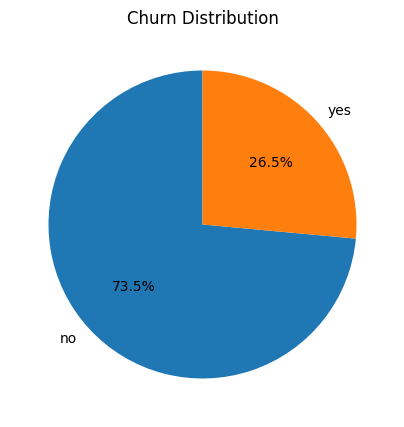

In [68]:
df_procesado['Churn'].value_counts(normalize=True).plot(
    kind='pie',
    autopct='%1.1f%%',  # Show percentages with 1 decimal
    startangle=90,      # Rotate so first slice starts at 12 o'clock
    figsize=(5,5),      # Optional: make it bigger
    ylabel='',          # Optional: remove ylabel
    title='Churn Distribution'
)

Podemos ver que **la variable target está desbalanceada**, lo que puede provocar sesgos al modelo, por lo que debe ser tomado en cuenta más adelante un balanceo.

Ahora veamos la distribución de las columnas numéricas a través de un histograma.

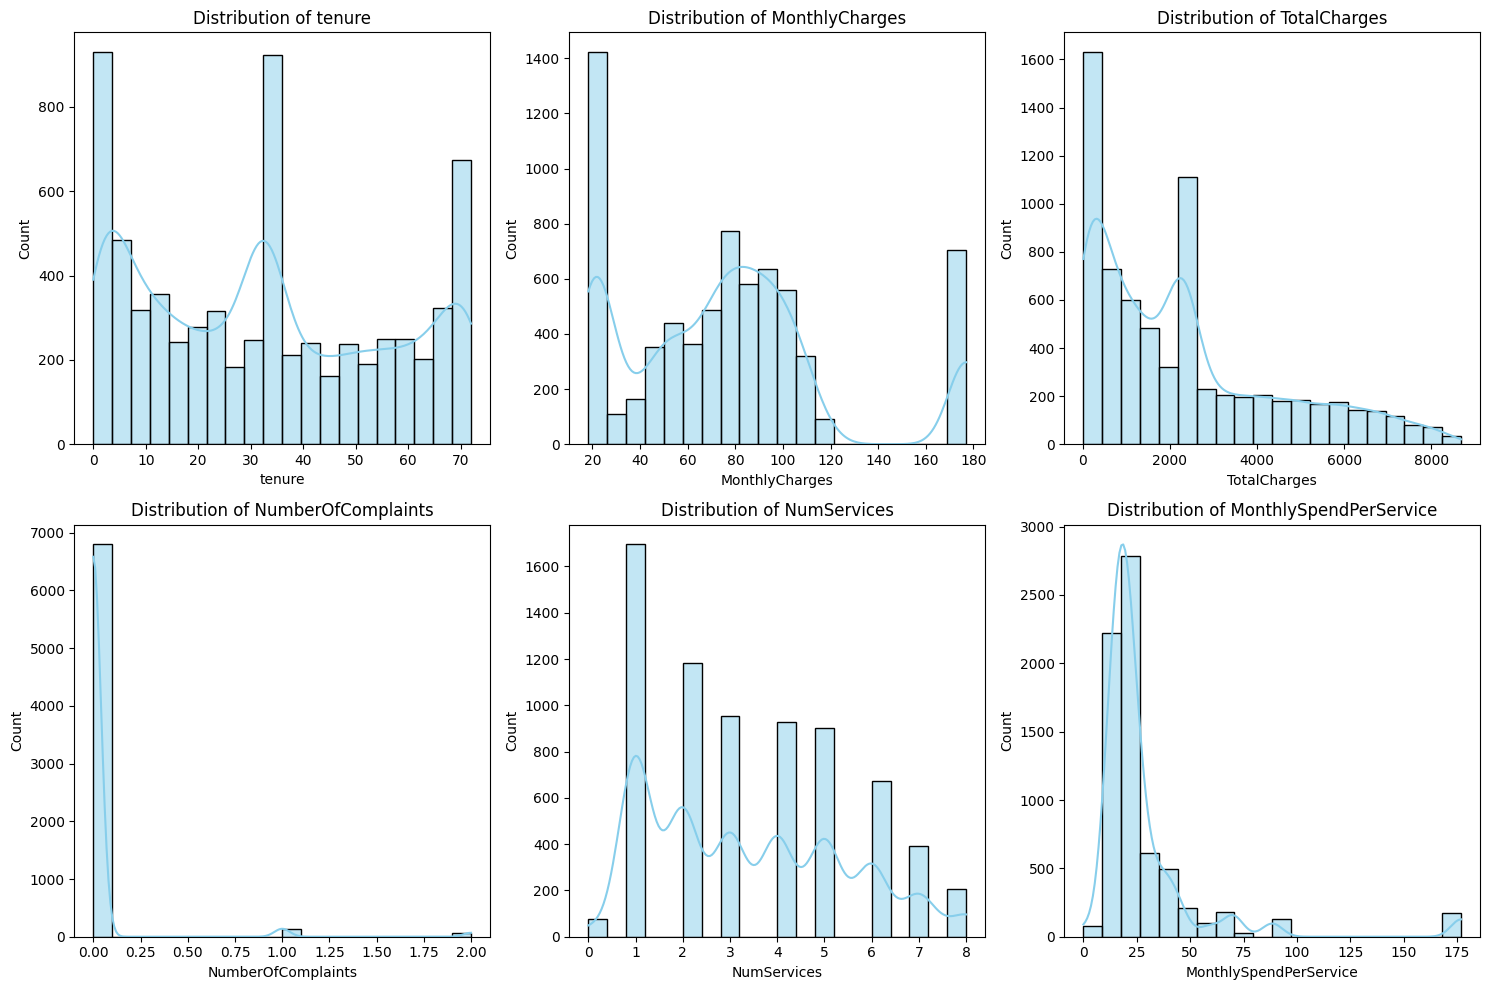

In [69]:
# Select numerical columns
numerical_cols = list(df_procesado.select_dtypes(include='number').columns)

# Set up grid
n_cols = 3  # number of columns in grid
n_rows = -(-len(numerical_cols) // n_cols)  # ceiling division for rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot each histogram
for i, col in enumerate(numerical_cols):
    sns.histplot(df_procesado[col], ax=axes[i], kde=True, color='skyblue', bins=20)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**📊 Análisis Univariado de Variables Numéricas**

A continuación se presentan los principales hallazgos sobre la distribución de las variables numéricas en el dataset de churn:

**🔹 1. Tenure (Meses de permanencia)**
- La distribución es **trimodal**, con picos notables en los extremos: clientes nuevos (0 meses) y clientes de largo plazo (70 meses).
- Esto sugiere que muchos clientes se van muy pronto o permanecen por varios años.

---

**🔹 2. MonthlyCharges (Cargos Mensuales)**
- La distribución es **trimodal** con un centro en formato gaussiano.
- La mayoría de los clientes pagan entre **20 y 100 unidades monetarias**.
- Existe un pequeño grupo de clientes con cargos altos (hasta 180), posiblemente asociados a servicios premium o múltiples servicios.

---

**🔹 3. TotalCharges (Cargos Totales)**
- La distribución está **sesgada a la derecha** (right-skewed).

---

**🔹 4. NumberOfComplaints (Número de Quejas)**
- La distribución está fuertemente concentrada en **0**: la gran mayoría de los clientes no han reportado quejas.
- Muy pocos clientes reportan 1 o más quejas, indicando que el dataset podría estar desequilibrado respecto a esta variable.

---

**🔹 5. NumServices (Número de Servicios Contratados)**
- La distribución muestra una ligera tendencia a valores bajos (1-3 servicios), aunque existe una caída progresiva hacia valores altos (hasta 8).
- Puede sugerir que los clientes tienden a contratar pocos servicios.

---

**🔹 6. MonthlySpendPerService (Gasto mensual por servicio)**
- La mayoría de los clientes gastan menos de **50 unidades monetarias** por servicio.
- Hay algunos casos extremos (valores >150) que podrían ser outliers o clientes con paquetes de servicios costosos.

---

**📌 Resumen**
- Variables como `TotalCharges` y `MonthlySpendPerService` presentan valores atípicos que podrían requerir tratamiento antes del modelado a través de una estandarización.
- La distribución de `Tenure` y `NumServices` revela patrones interesantes sobre la permanencia y el nivel de contratación de servicios por parte de los clientes.  
- `NumberOfComplaints` tiene un fuerte sesgo hacia cero, lo que puede limitar su valor predictivo.



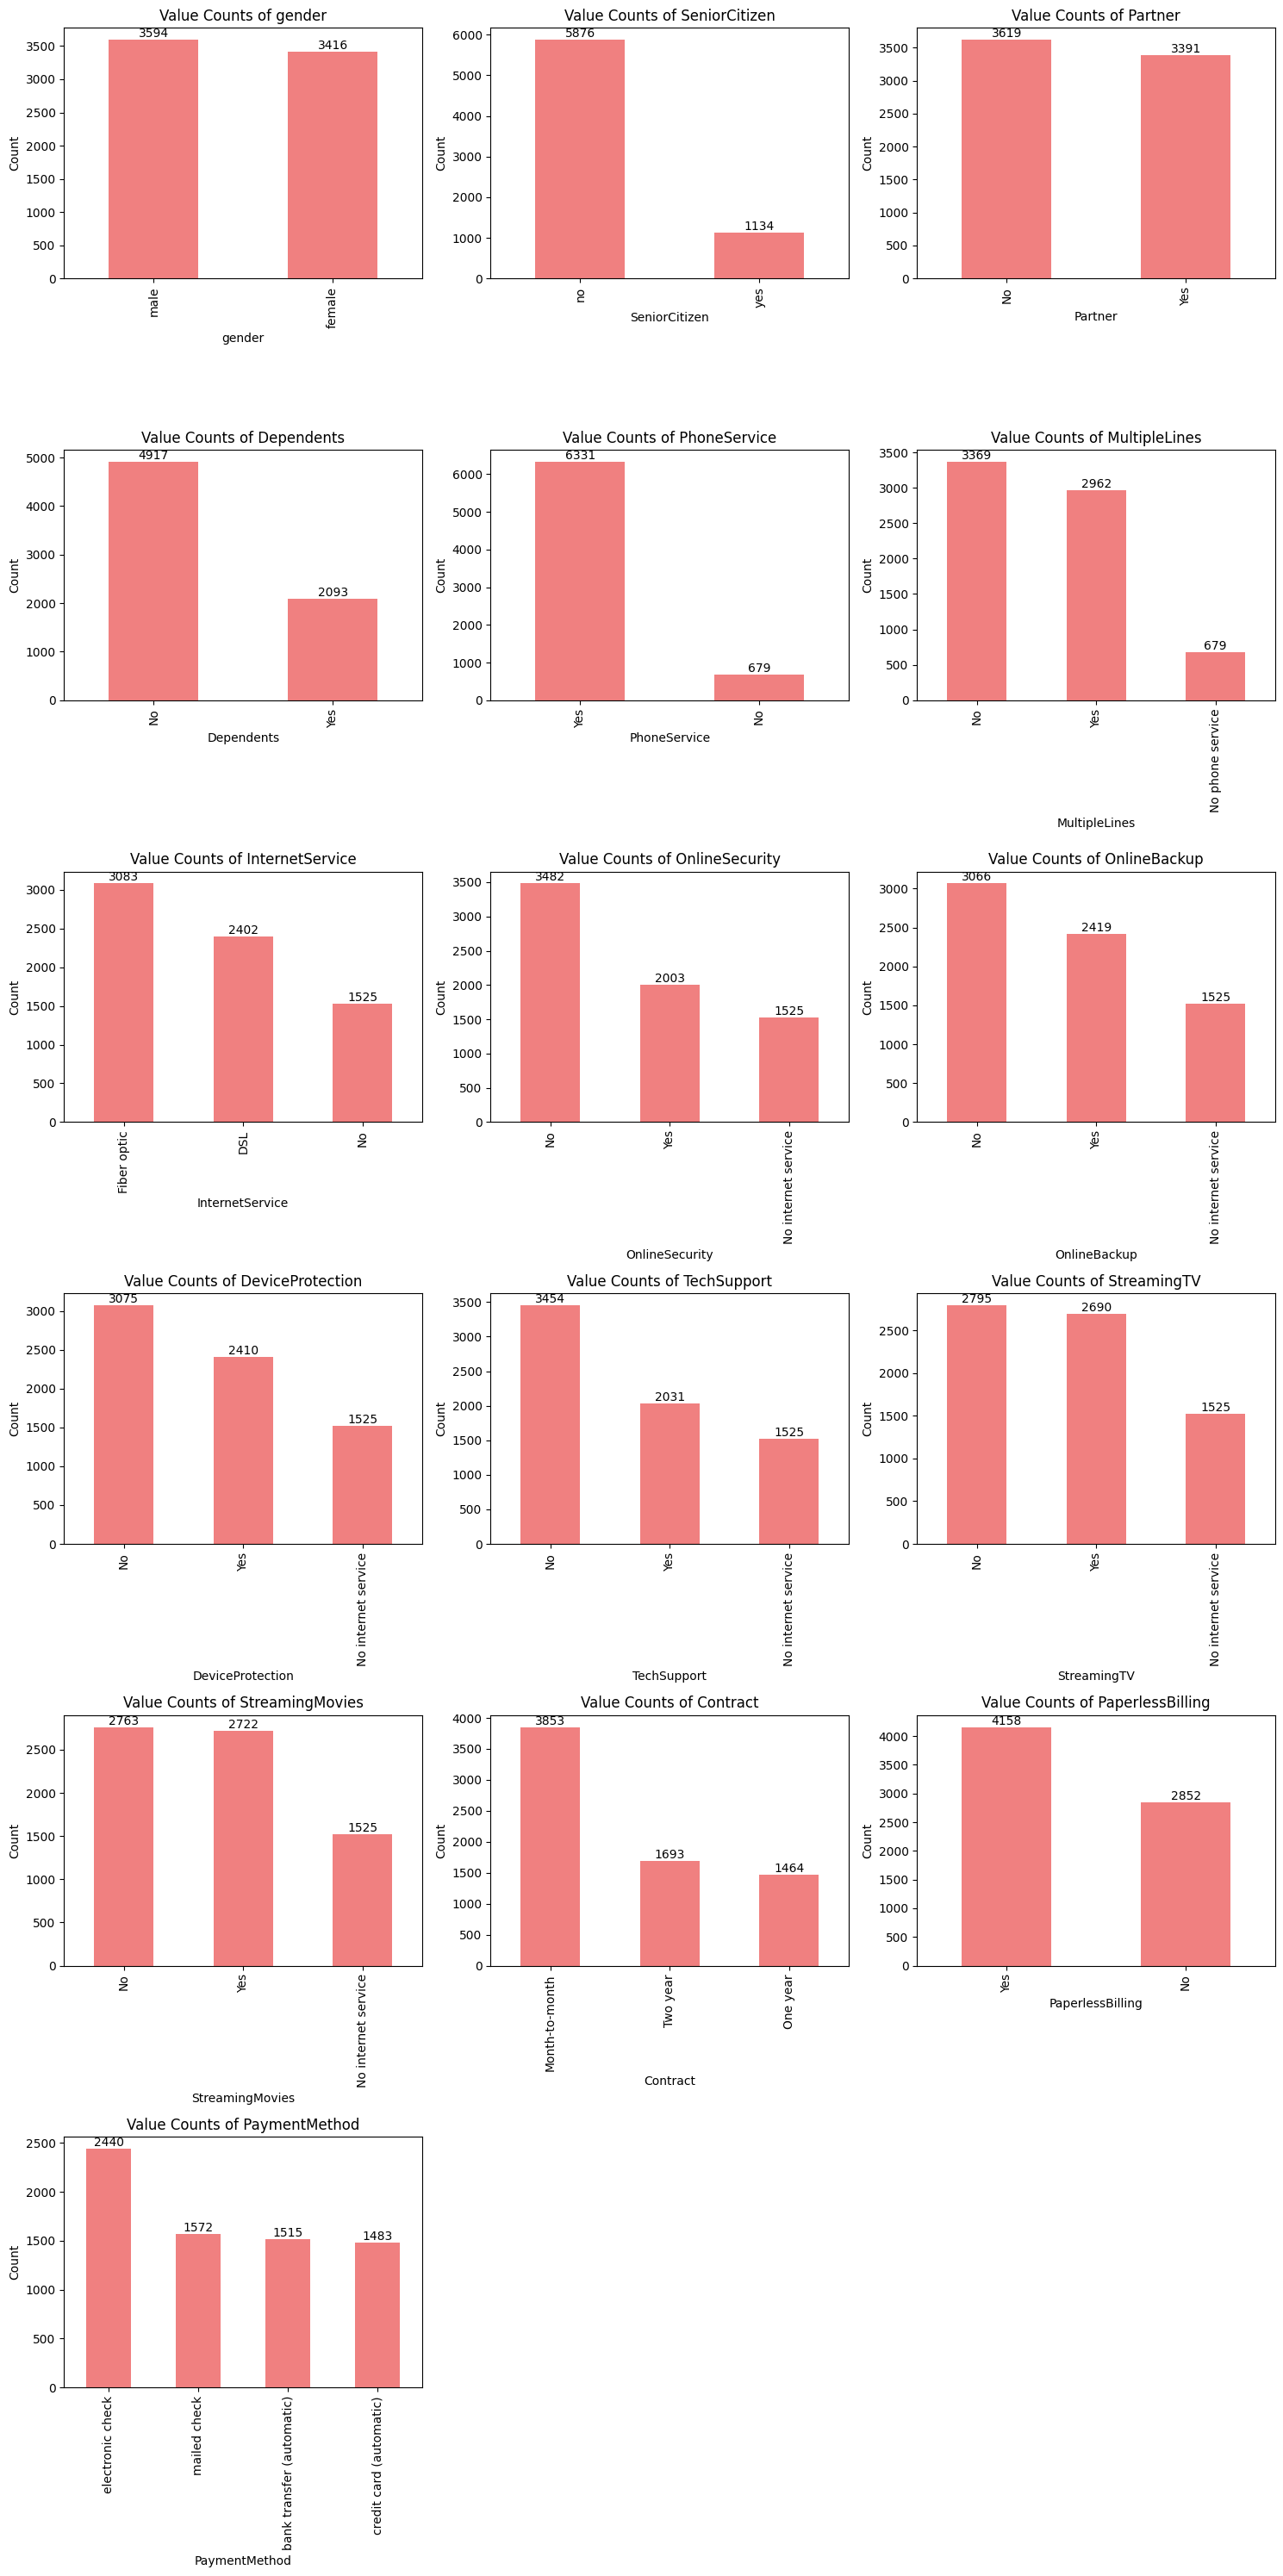

In [70]:
# Select categorical columns
categorical_cols = list(df_procesado.drop("Churn", axis=1).select_dtypes(include='object').columns)

# Set up grid
n_cols = 3
n_rows = -(-len(categorical_cols) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot each bar chart
for i, col in enumerate(categorical_cols):
    df_procesado[col].value_counts().plot(kind='bar', ax=axes[i], color='lightcoral')
    axes[i].bar_label(axes[i].containers[0], label_type='edge')
    axes[i].set_title(f'Value Counts of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**📊 Análisis Univariado de Variables Categóricas**

A continuación se presentan los principales hallazgos sobre la distribución de las variables categóricas en el dataset de churn:

- Variables en general son de baja cardinalidad lo cual es bueno y hace que no se requiera agrupaciones en "Otros".
- Las variables tiene una distribución no desbalanceada extrema, por lo que no requerirá de revisión adicional ni procesamiento especial.
- La distribución de `gender`, `Partner` y otras variables demográficas está bien equilibrada por lo que tenemos una población diversa  y no sesgada.
- Dada la baja cardinalidad de las columnas `OneHotEncoding` no provocará una explosión de dimensionalidad severa.
- La categoría `No internet service` se encuentra en variables diferentes pero representa lo mismo que el `No` de la variable `InternetService`. Esto provocará que post-encoding se dupliquen columnas, por lo que será necesario aplicar un feature selection post-encoding para evitar este problema.

### Análisis bivariado

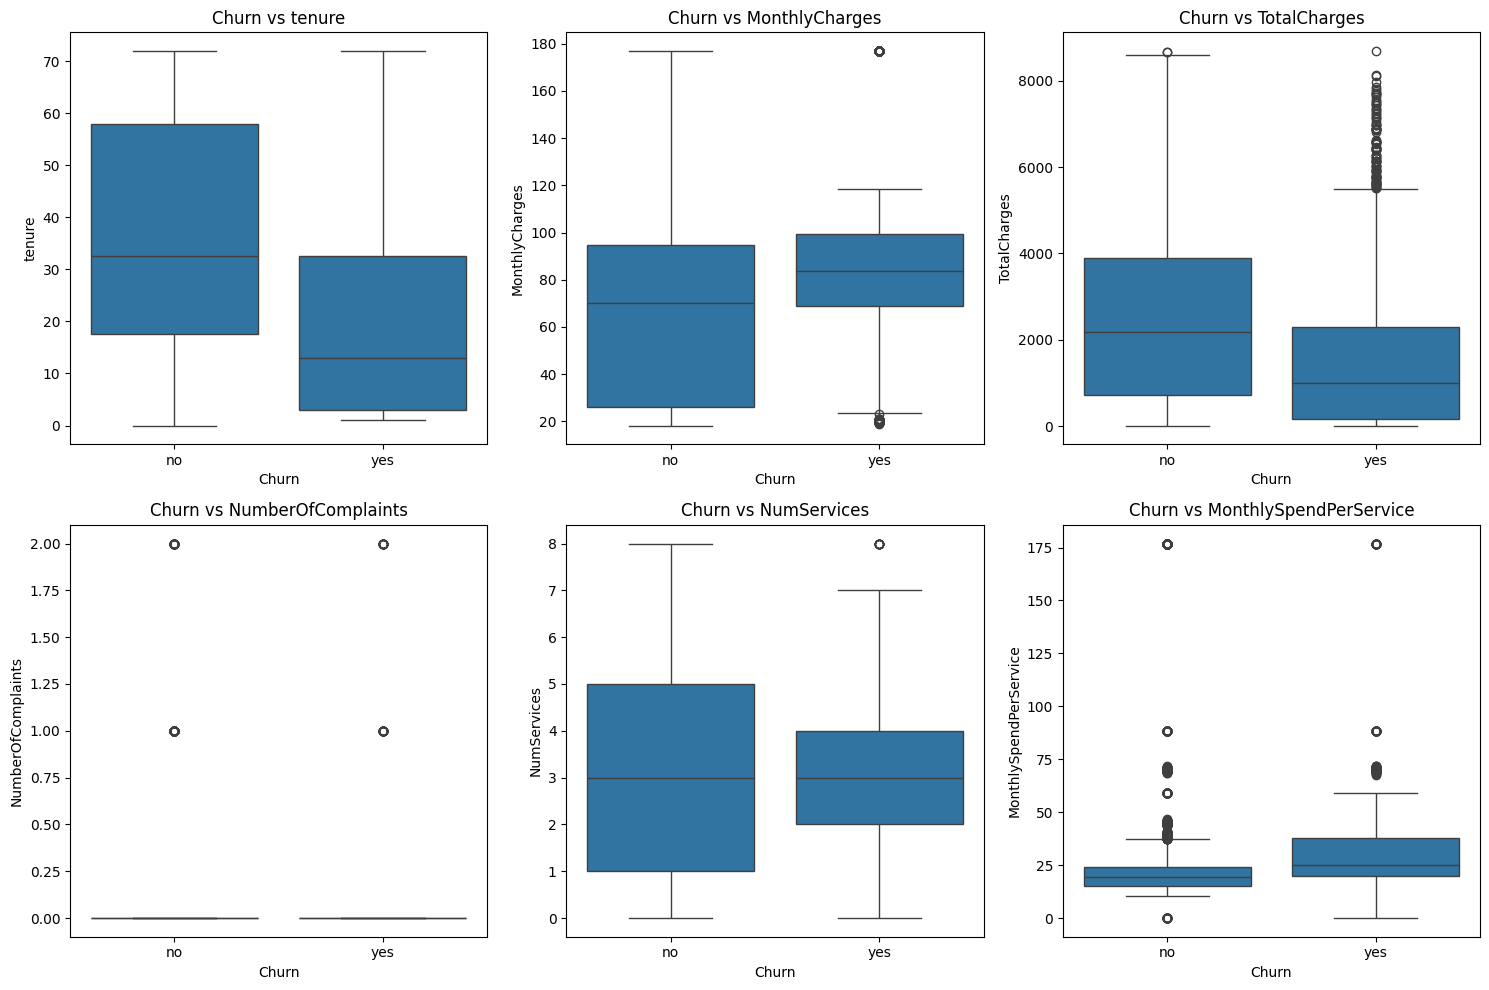

In [71]:
# Set up grid
n_cols = 3
n_rows = -(-len(numerical_cols) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot each bar chart
for i, col in enumerate(numerical_cols):
    sns.boxplot(x='Churn', y=col, data=df_procesado, ax=axes[i])
    axes[i].set_title(f'Churn vs {col}')
    axes[i].set_xlabel('Churn')
    axes[i].set_ylabel(col)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**🔥 Análisis Bivariado: Churn vs Variables Numéricas**

Se presentan los hallazgos clave de la comparación entre clientes que abandonaron el servicio (`Churn = yes`) y los que permanecieron (`Churn = no`):

---

**🔹 1. tenure (Meses de permanencia)**
- Los clientes que abandonaron tienen una **mediana de permanencia significativamente menor** en comparación con los que permanecieron.
- Esto indica que la deserción ocurre con mayor frecuencia en los primeros meses de relación con la empresa.

---

**🔹 2. MonthlyCharges (Cargos Mensuales)**
- Los clientes que se dieron de baja tienden a tener **cargos mensuales más altos** en comparación con los clientes que permanecen.
- Esto podría sugerir que los planes o servicios con costos elevados podrían estar asociados a una mayor probabilidad de churn.

---

**🔹 3. TotalCharges (Cargos Totales)**
- Los clientes que permanecen presentan **cargos totales acumulados considerablemente mayores**, lo cual es consistente con su mayor tiempo de permanencia.
- Los clientes que abandonan tienen cargos totales más bajos, reflejando su corta duración como clientes.

---

**🔹 4. NumberOfComplaints (Número de Quejas)**
- No se observa una diferencia significativa entre clientes que abandonan y los que permanecen, ya que la mayoría no tiene quejas registradas.
- Los pocos valores de 1 o 2 quejas aparecen tanto en clientes activos como en los que churnearon.

---

**🔹 5. NumServices (Número de Servicios Contratados)**
- Los clientes que permanecen tienden a tener un **mayor número de servicios contratados** (mediana más alta).
- Los clientes con menos servicios parecen estar más propensos a la deserción.

---

**🔹 6. MonthlySpendPerService (Gasto Mensual por Servicio)**
- Los clientes que se dieron de baja muestran una **ligera tendencia a gastar más por servicio individualmente**.
- Esto podría indicar que clientes con menos servicios pero de alto costo son más propensos a abandonar.

---

**📌 Conclusiones**
- **Mayor riesgo de churn**: clientes nuevos (bajo `tenure`), con **altos cargos mensuales**, y que contratan **pocos servicios**.  
- **Menor riesgo de churn**: clientes con mayor permanencia y más servicios contratados, aunque con un gasto mensual promedio por servicio más bajo.



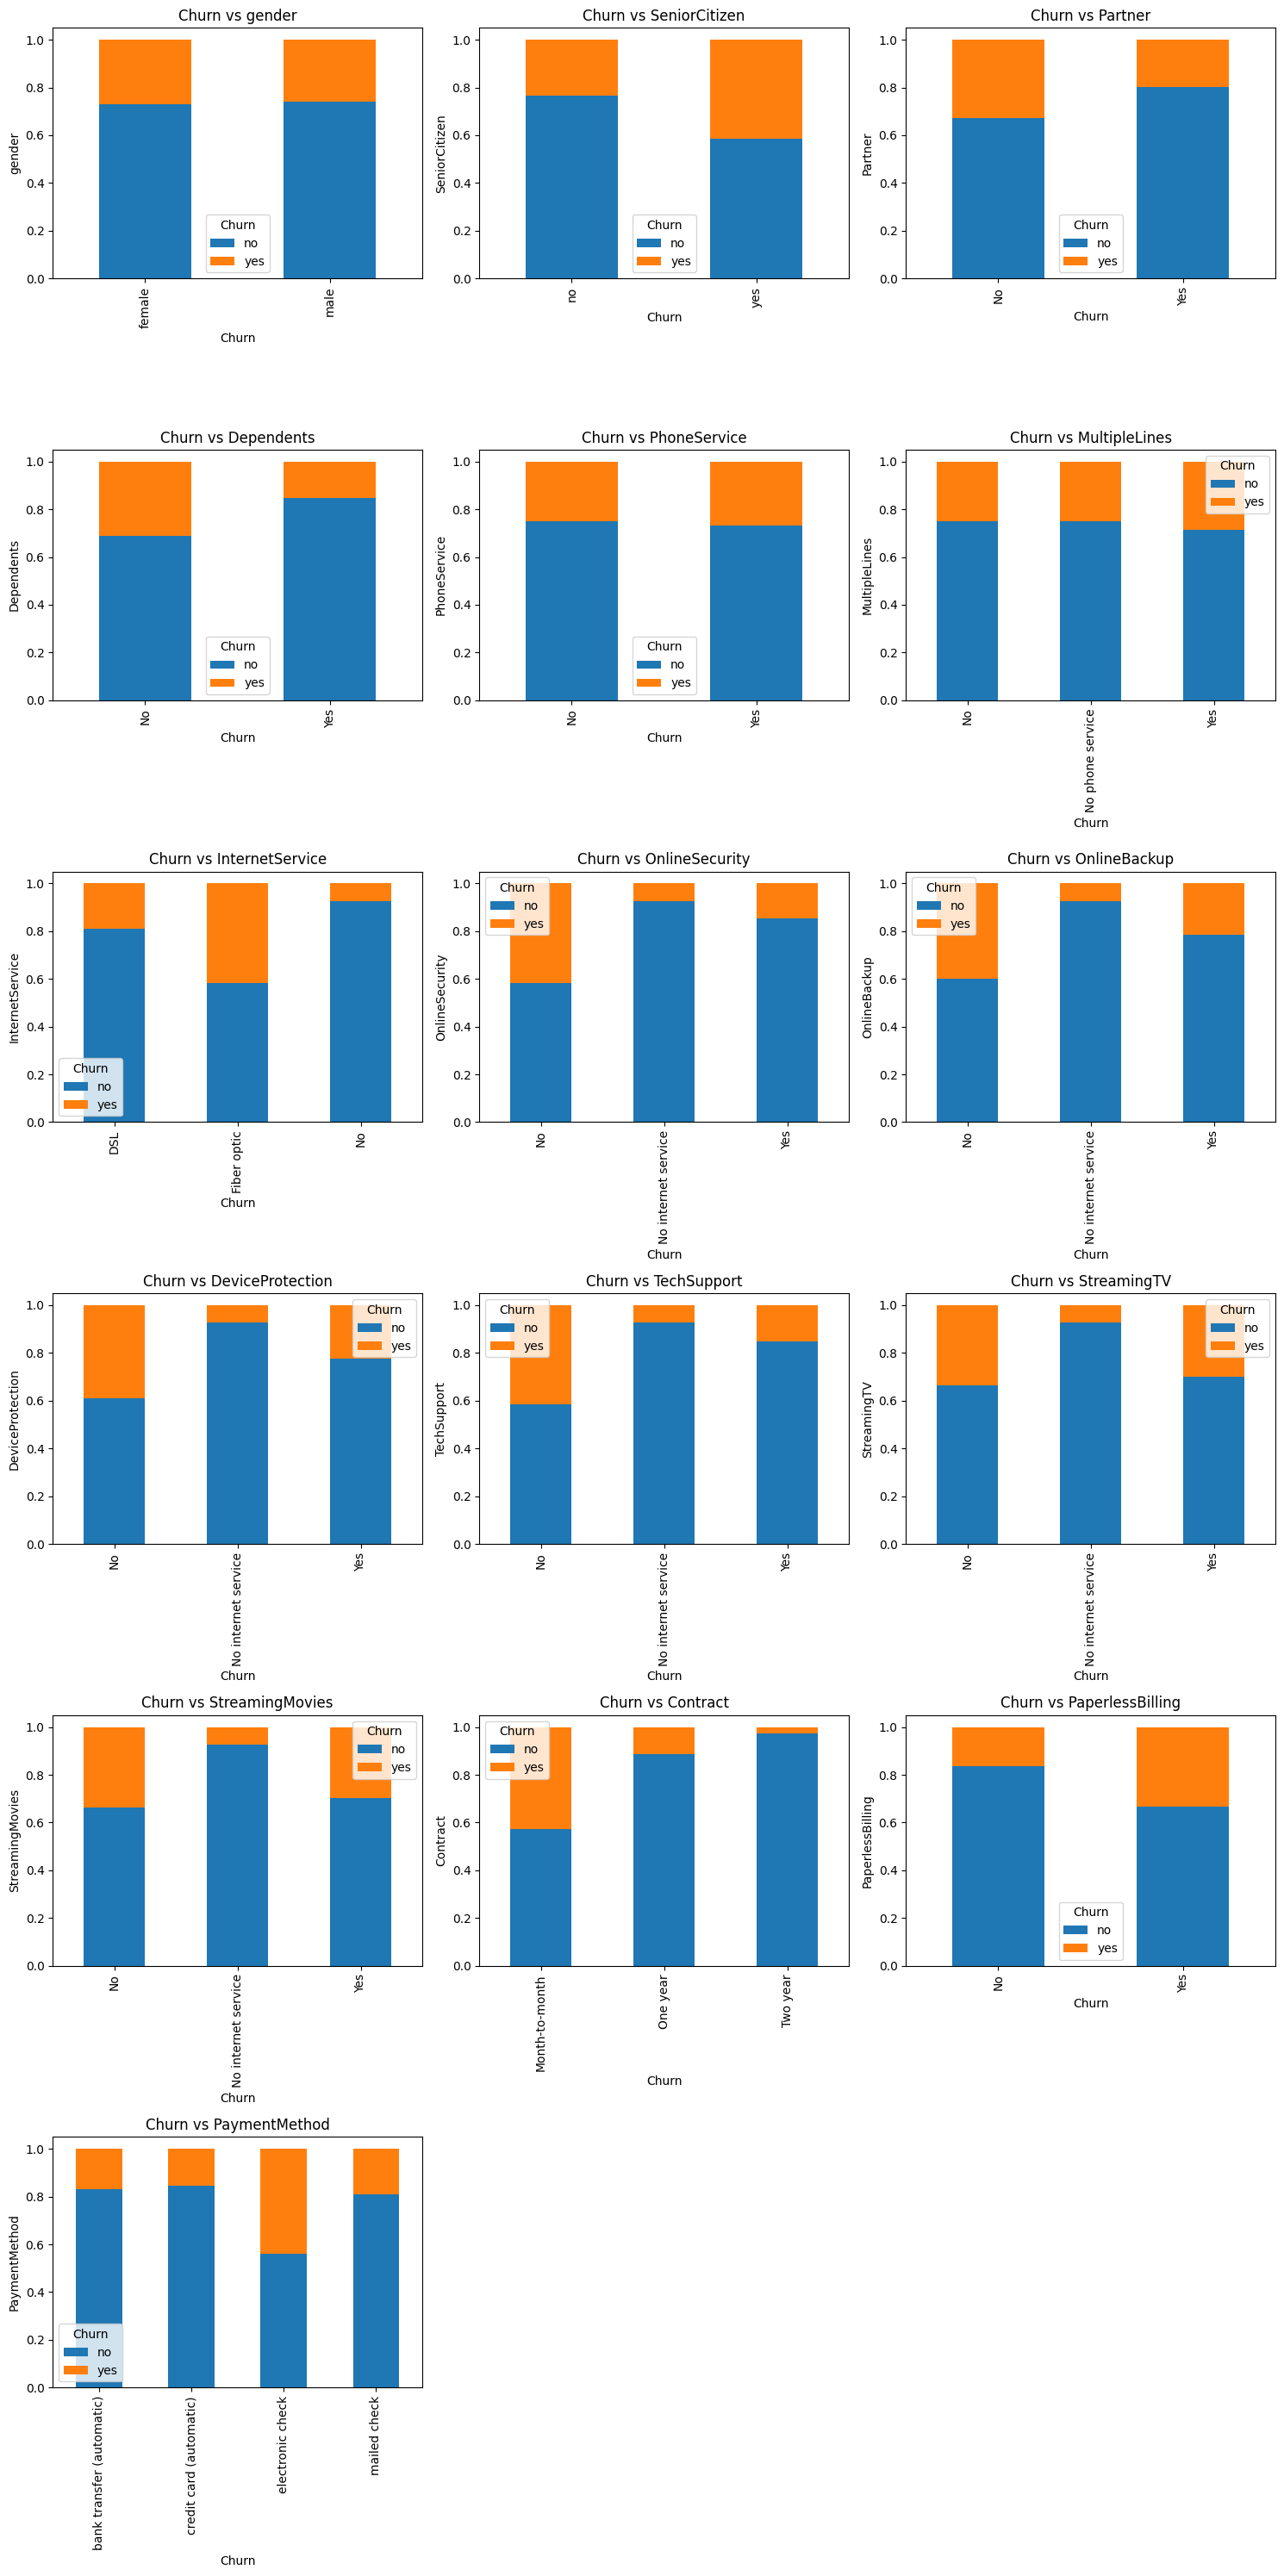

In [72]:
# Set up grid
n_cols = 3
n_rows = -(-len(categorical_cols) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot each bar chart
for i, col in enumerate(categorical_cols):
    pd.crosstab(df_procesado[col], df_procesado['Churn'], normalize='index').plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'Churn vs {col}')
    axes[i].set_xlabel('Churn')
    axes[i].set_ylabel(col)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**🔥 Análisis Bivariado: Churn vs Variables Categóricas**

Se presentan los hallazgos clave de la comparación entre clientes que abandonaron el servicio (`Churn = yes`) y los que permanecieron (`Churn = no`):

- **Mayor riesgo de churn**: clientes más digitales y ocasionales, que pagan electrónicamente, sin factura física, y están suscritos a corto plazo (mes a mes).
- **Menor riesgo de churn**: clientes con mayor permanencia y más tradicionales Generalmente tienen suscripciones por 2 años.
- El género y otros demográficos tienen poca influencia directa en la deserción.



### Correlaciones

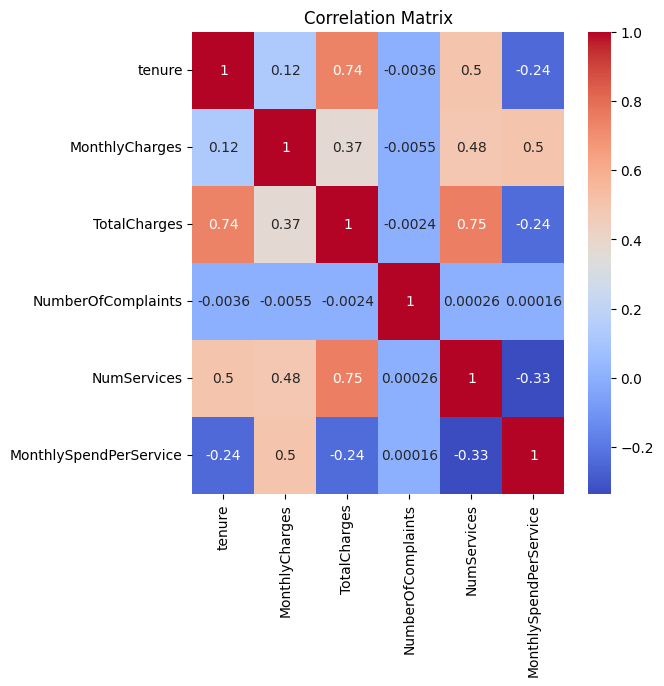

In [73]:
# Plot numerical correlations
plt.figure(figsize=(6,6))
sns.heatmap(df_procesado[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**🔗 Análisis de Correlación entre Variables Numéricas**

A continuación se resumen los principales hallazgos obtenidos de la matriz de correlación:

**🔹 1. Relación fuerte**
- **`TotalCharges` ↔ `tenure` (r = 0.74):** Existe una fuerte correlación positiva. A mayor permanencia del cliente, mayor es el cargo total acumulado, lo cual es esperado.
- **`TotalCharges` ↔ `NumServices` (r = 0.75):** Los clientes que contratan más servicios tienden a acumular cargos totales más altos.

---

**🔹 2. Relación moderada**
- **`NumServices` ↔ `MonthlyCharges` (r = 0.48):** Correlación positiva moderada. A mayor número de servicios, tienden a incrementarse los cargos mensuales.
- **`tenure` ↔ `NumServices` (r = 0.50):** Clientes con más tiempo de permanencia suelen tener más servicios contratados.

---

**🔹 3. Correlación negativa**
- **`MonthlySpendPerService` ↔ `NumServices` (r = -0.33):** Relación inversa moderada. Mientras más servicios contrata un cliente, menor es el gasto mensual promedio por servicio, probablemente por descuentos en paquetes o bundling.
- **`tenure` ↔ `MonthlySpendPerService` (r = -0.24):** Los clientes antiguos tienden a gastar menos en promedio por servicio, posiblemente por planes antiguos o mejores tarifas.

---

**🔹 4. Relación muy débil o inexistente**
- **`NumberOfComplaints` con todas las demás variables** (r ≈ 0): No hay correlación significativa. El número de quejas no parece estar relacionado con otras métricas como cargos o permanencia.

---

**📌 Conclusiones**
- Variables altamente correlacionadas como `TotalCharges`, `tenure` y `NumServices` podrían indicar redundancia, por lo que sería recomendable evaluar la multicolinealidad antes de usarlas en un modelo predictivo.
- La correlación negativa entre `MonthlySpendPerService` y `NumServices` sugiere que los clientes con más servicios pueden beneficiarse de descuentos.
- `NumberOfComplaints` podría no aportar valor predictivo directo dada su falta de correlación.


<Figure size 1200x800 with 0 Axes>

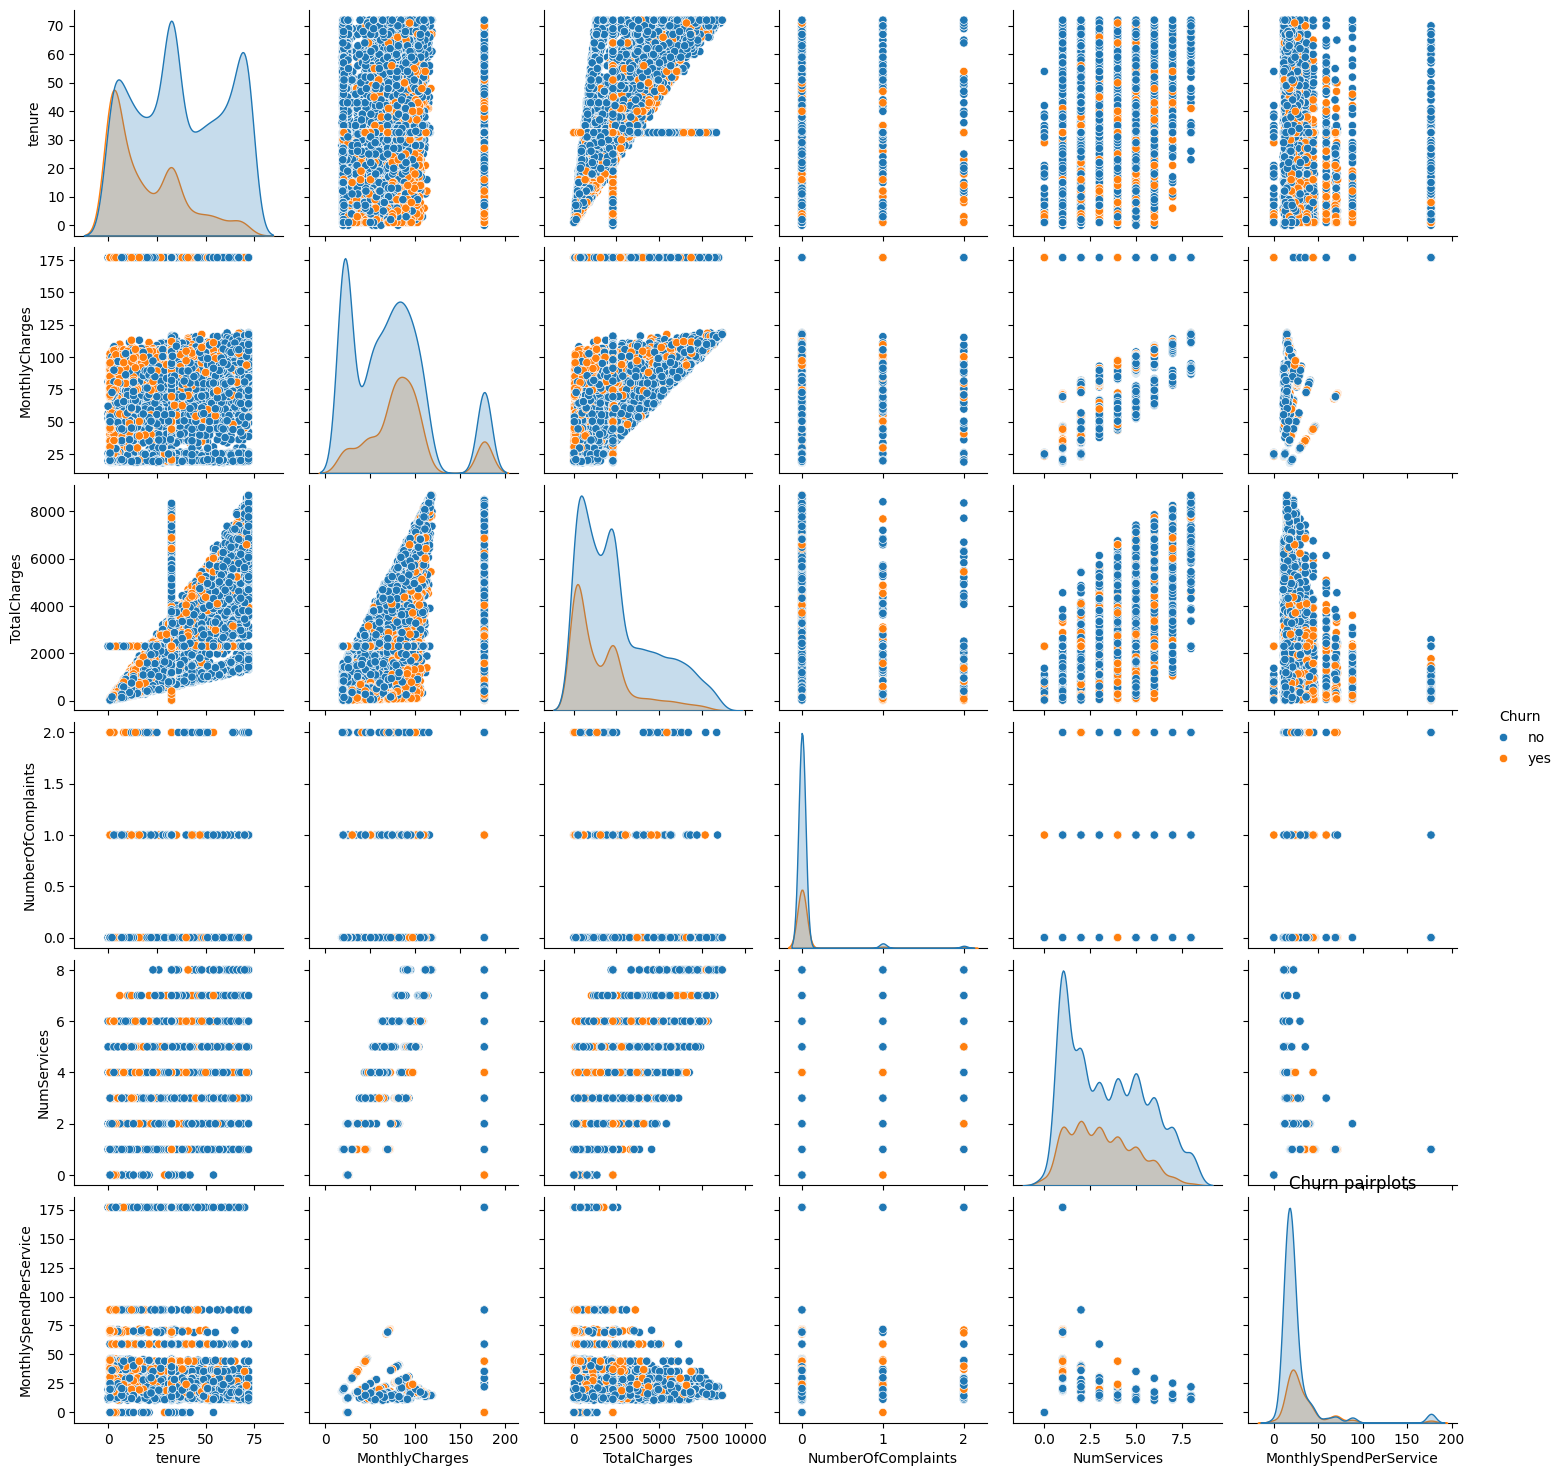

In [74]:
# Plot pairplots with target
plt.figure(figsize=(12, 8))
sns.pairplot(df_procesado[numerical_cols + ["Churn"]], hue='Churn')
plt.title('Churn pairplots')
plt.show()

Este vista no nos ofrece información relevante sobre las variables más que a nivel de pares las interacciones de variables no denotan un patrón explícito con respecto a la target, por lo cual será necesario un método que explore relaciones entre variables de forma efectiva cuando se modelo.

## Normalización & Encoding

**⚙️ Preprocesamiento: Estandarización, Codificación y Balanceo de Datos**

Antes de construir un modelo predictivo para churn, realizaremos un proceso de preprocesamiento de datos que incluye **estandarización de variables numéricas**, **codificación de variables categóricas** y **balanceo de clases**. Este paso es fundamental para asegurar un rendimiento óptimo del modelo.

---

**🔹 1. Estandarización de Variables Numéricas**
- **¿Qué es?**
  La estandarización transforma las variables numéricas para que tengan una media de 0 y una desviación estándar de 1.
- **¿Por qué?**
  - Evita que variables con escalas diferentes dominen el aprendizaje del modelo.
  - Mejora la convergencia en algoritmos sensibles a la escala, como regresión logística, SVM o redes neuronales.
- **Herramienta a utilizar:**
  - `StandardScaler` de **scikit-learn**.

---

**🔹 2. Codificación de Variables Categóricas**
- **¿Qué es?**
  La codificación convierte las variables categóricas en un formato numérico que pueda ser interpretado por algoritmos de machine learning.
- **¿Por qué?**
  - La mayoría de los modelos no pueden trabajar directamente con variables de tipo string.
  - Permite representar categorías sin introducir un orden artificial.
- **Método seleccionado:**
  - **One-Hot Encoding** mediante `OneHotEncoder` de **scikit-learn**, que crea una nueva columna binaria por cada categoría presente en la variable.

---

**🔹 3. Balanceo de Clases**
- **¿Qué es?**
  El balanceo ajusta la proporción de clases en el conjunto de datos para evitar que el modelo se sesgue hacia la clase mayoritaria.
- **¿Por qué?**
  - El dataset actual muestra una proporción desigual entre clientes que churnean y los que no.
  - Sin balanceo, el modelo puede predecir siempre la clase mayoritaria y obtener una alta precisión engañosa.
- **Método seleccionado:**
  - **Random Under Sampling** usando `RandomUnderSampler` de la librería **imbalanced-learn**, que reduce la clase mayoritaria para igualar la cantidad de observaciones de la clase minoritaria.

---

**📌 Resumen de herramientas**

| Paso                   | Herramienta              |
|------------------------|---------------------------|
| Estandarización        | `StandardScaler`          |
| Codificación           | `OneHotEncoder`           |
| Balanceo de clases     | `RandomUnderSampler`      |

---

Ahora aplicaremos estos procesos como parte de un pipeline de preprocesamiento para garantizar un flujo de trabajo limpio y reproducible antes del entrenamiento del modelo.


In [75]:
# Transformers específicos
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='if_binary', sparse_output=False)  # sparse_output=False para DataFrame

# ColumnTransformer
vectorizer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

df_vectorizado = pd.DataFrame(vectorizer.fit_transform(df_procesado), columns=vectorizer.get_feature_names_out(), index=df_procesado.index)
df_vectorizado

,num__tenure,num__MonthlyCharges,num__TotalCharges,num__NumberOfComplaints,num__NumServices,num__MonthlySpendPerService,cat__gender_male,cat__SeniorCitizen_yes,cat__Partner_Yes,cat__Dependents_Yes,...,cat__StreamingMovies_No internet service,cat__StreamingMovies_Yes,cat__Contract_Month-to-month,cat__Contract_One year,cat__Contract_Two year,cat__PaperlessBilling_Yes,cat__PaymentMethod_bank transfer (automatic),cat__PaymentMethod_credit card (automatic),cat__PaymentMethod_electronic check,cat__PaymentMethod_mailed check
0,-1.357103,-1.044670,-1.062966,-0.166208,-1.146561,0.059092,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.063271,-0.431247,-0.191325,-0.166208,-0.175744,-0.329317,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.000188,-0.762857,-0.214174,-0.166208,-0.175744,-0.503862,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.314061,-0.120008,-1.005877,-0.166208,-1.146561,1.519198,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5,-1.055811,0.535291,-0.692378,-0.166208,0.795073,-0.295480,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,-1.314061,-0.077000,-1.004635,-0.166208,-0.661153,0.289635,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7174,0.321521,0.477571,0.660537,-0.166208,0.309664,-0.140176,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7177,1.483645,0.672236,2.118233,-0.166208,1.280482,-0.378166,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
7179,-1.098853,-1.252917,-1.014126,-0.166208,-1.146561,-0.269745,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [76]:
# Eliminar correlaciones post-vectorización

print(f"Antes el dataset tiene {df_vectorizado.shape[1]} features")

postprocess = make_pipeline(
    DropDuplicateFeatures(),
    DropCorrelatedFeatures(),
)

df_vectorizado = postprocess.fit_transform(df_vectorizado)
print(f"Ahora el dataset tiene {df_vectorizado.shape[1]} features")

df_vectorizado

Antes el dataset tiene 43 features
Ahora el dataset tiene 35 features


,num__tenure,num__MonthlyCharges,num__TotalCharges,num__NumberOfComplaints,num__NumServices,num__MonthlySpendPerService,cat__gender_male,cat__SeniorCitizen_yes,cat__Partner_Yes,cat__Dependents_Yes,...,cat__StreamingMovies_No,cat__StreamingMovies_Yes,cat__Contract_Month-to-month,cat__Contract_One year,cat__Contract_Two year,cat__PaperlessBilling_Yes,cat__PaymentMethod_bank transfer (automatic),cat__PaymentMethod_credit card (automatic),cat__PaymentMethod_electronic check,cat__PaymentMethod_mailed check
0,-1.357103,-1.044670,-1.062966,-0.166208,-1.146561,0.059092,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.063271,-0.431247,-0.191325,-0.166208,-0.175744,-0.329317,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.000188,-0.762857,-0.214174,-0.166208,-0.175744,-0.503862,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.314061,-0.120008,-1.005877,-0.166208,-1.146561,1.519198,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5,-1.055811,0.535291,-0.692378,-0.166208,0.795073,-0.295480,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,-1.314061,-0.077000,-1.004635,-0.166208,-0.661153,0.289635,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7174,0.321521,0.477571,0.660537,-0.166208,0.309664,-0.140176,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7177,1.483645,0.672236,2.118233,-0.166208,1.280482,-0.378166,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
7179,-1.098853,-1.252917,-1.014126,-0.166208,-1.146561,-0.269745,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [189]:
# Separación de vectores en (X,y) [features, label] y balanceo

X, y = df_vectorizado, df_procesado['Churn']

print("Antes del balanceo")
print(y.value_counts())
print(y.value_counts(normalize=True))

rud = RandomUnderSampler(random_state=40)
X_resampled, y_resampled = rud.fit_resample(X, y)

print("-"*100)
print("Después del balanceo")
print(y_resampled.value_counts())
print(y_resampled.value_counts(normalize=True))

Antes del balanceo
Churn
no     5155
yes    1855
Name: count, dtype: int64
Churn
no     0.735378
yes    0.264622
Name: proportion, dtype: float64
----------------------------------------------------------------------------------------------------
Después del balanceo
Churn
no     1855
yes    1855
Name: count, dtype: int64
Churn
no     0.5
yes    0.5
Name: proportion, dtype: float64


In [190]:
# Codificamos la etiqueta

print("Etiquetas antes:")
print(pd.Series(y_resampled).unique())

le = LabelEncoder()
le.fit(["no", "yes"])
y_resampled = pd.Series(le.transform(y_resampled), index=y_resampled.index, name=y_resampled.name)

print("Etiquetas después:")
print(pd.Series(y_resampled).unique())

Etiquetas antes:
['no' 'yes']
Etiquetas después:
[0 1]


## Entrenamiento básico

Ahora que tenemos la data preparada como vectores numéricos depurados y filtrados podemos **entrenar nuestro primer modelo de ML**.

Para este primer ejemplo, usaremos **regresión logística**.

Para lograr este objetivo:


1.   Primero separamos la data en 2 porciones, una para entrenar y otra para evaluar el rendimiento del modelo. Usaremos el 20% de la data para evaluación.
2.   Luego entrenamos el modelo usando la clase de la librería SKLearn.



In [191]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (2968, 35)
X_test: (742, 35)


In [192]:
# Ahora entrenamos nuestro modelo de regresión logística
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [193]:
#  Listo! Ahora pidamos al modelo una predicción de los clientes de testing
y_pred = lr.predict(X_test)
pd.DataFrame(pd.concat(
    [X_test,
     y_test,
     pd.Series(y_pred, index=y_test.index, name="Predicción"),
     ], axis=1))

,num__tenure,num__MonthlyCharges,num__TotalCharges,num__NumberOfComplaints,num__NumServices,num__MonthlySpendPerService,cat__gender_male,cat__SeniorCitizen_yes,cat__Partner_Yes,cat__Dependents_Yes,...,cat__Contract_Month-to-month,cat__Contract_One year,cat__Contract_Two year,cat__PaperlessBilling_Yes,cat__PaymentMethod_bank transfer (automatic),cat__PaymentMethod_credit card (automatic),cat__PaymentMethod_electronic check,cat__PaymentMethod_mailed check,Churn,Predicción
6646,0.794979,-1.281211,-0.609299,-0.166208,-1.146561,-0.314424,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
4755,0.020230,0.345153,0.312331,-0.166208,-0.175744,0.079346,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1
5047,0.278479,-0.064551,0.203027,-0.166208,-0.661153,0.299464,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,1
5916,1.698853,0.831817,2.763018,-0.166208,2.251299,-0.504086,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0,0
4475,-1.271019,-1.277816,-1.048342,-0.166208,-1.146561,-0.309062,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2629,-1.314061,-0.120008,-1.011009,-0.166208,-1.146561,1.519198,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1
6983,-0.410187,0.162936,-0.124392,-0.166208,0.309664,-0.264383,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
5428,-1.012770,0.304409,-0.677098,-0.166208,-0.175744,0.057900,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
6742,0.838021,0.072394,0.805533,-0.166208,1.280482,-0.536031,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0


In [194]:
# Veamos la probabilidad que el modelo tiene de la respuesta.
y_pred_prob = lr.predict_proba(X_test)
pd.DataFrame(pd.concat(
    [y_test,
     pd.Series(y_pred, index=y_test.index, name="Predicción"),
     pd.Series(y_pred_prob[:, 1], index=y_test.index, name="Probabilidad de Churn"),
     ], axis=1))

,Churn,Predicción,Probabilidad de Churn
6646,0,0,0.066125
4755,0,1,0.759783
5047,0,1,0.685917
5916,0,0,0.090412
4475,0,0,0.442080
...,...,...,...
2629,1,1,0.785262
6983,0,1,0.500846
5428,1,1,0.855124
6742,0,0,0.070357


## Validación del modelo

**Evaluación del Modelo de Clasificación**

Para evaluar el desempeño de nuestro modelo de regresión logística, utilizaremos varias **métricas** y **gráficas** que nos permiten entender su comportamiento desde diferentes perspectivas:

**Métricas principales**

- **Accuracy (Exactitud)**: Proporción de predicciones correctas sobre el total de casos.
- **Precision (Precisión)**: De todas las predicciones positivas, cuántas son realmente positivas.
- **Recall (Sensibilidad o Exhaustividad)**: De todos los casos positivos reales, cuántos fueron correctamente identificados.
- **F1 Score**: Media armónica entre precisión y recall, útil cuando hay desequilibrio entre clases.
- **ROC AUC (Área bajo la curva ROC)**: Mide la capacidad del modelo para distinguir entre clases en diferentes umbrales.

**Matriz de Confusión**

Una tabla que muestra la cantidad de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos, ayudándonos a visualizar los errores y aciertos del modelo.

**Reporte de Clasificación**

Un resumen que incluye todas las métricas principales para cada clase, facilitando una evaluación detallada.

**Curvas para evaluación visual**

- **Curva ROC (Receiver Operating Characteristic)**: Grafica la tasa de verdaderos positivos frente a la tasa de falsos positivos a distintos umbrales.
- **Curva Precision-Recall**: Muestra la relación entre precisión y recall para diferentes umbrales, útil especialmente en datasets con clases desbalanceadas.
- **Average Precision Score**: Es el área bajo la curva Precision-Recall, resume el rendimiento general del modelo en esta curva.

Con estas herramientas podemos entender mejor cómo está funcionando nuestro modelo y detectar posibles mejoras.


In [195]:
# Primero evaluemos la exactitud de este modelo, esto representa qué porcentaje de predicciones hizo correctas.
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7560646900269542


Vemos que el modelo es medianamente exacto, **acierta el 76% de veces** si el cliente es desertor o no. Como referencia es mucho mejor que adivinar una clase al azar que representa un 50% de exactitud. Generando de forma básica un **uplift de +26%**

In [196]:
# Veamos ahora la precisión y el recall
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")

Precision: 0.7107843137254902
Recall: 0.8215297450424929


Vemos que el modelo tiende a abarcar medianamente bien a los clientes desertores **(82% de ellos es detectado correctamente)**, pero eso en perjuicio de un precisión más baja **(71% de clientes que se dice que son desertores realmente no lo son)**

In [197]:
# Veamos el resumen general
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.70      0.75       389
           1       0.71      0.82      0.76       353

    accuracy                           0.76       742
   macro avg       0.76      0.76      0.76       742
weighted avg       0.76      0.76      0.76       742



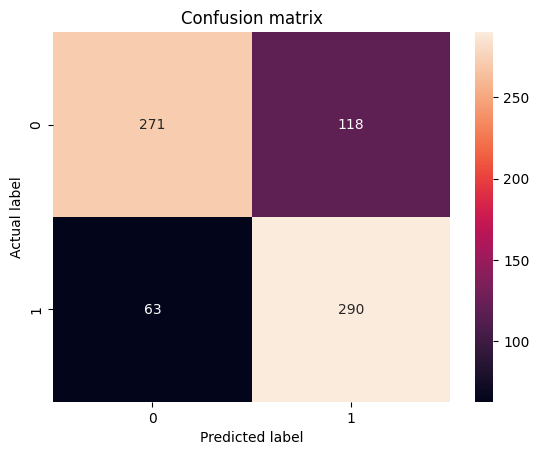

In [198]:
# Analicemos la matriz de confusión para entender mejor áreas de mejora
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

La matriz de confusión no reafirma lo que el recall y la precisión señalaban.

In [199]:
# Revisemos porcentaje de falsos positivos y negativos
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"False Positive Rate: {fp / (fp + tn)}")
print(f"False Negative Rate: {fn / (fn + tp)}")

False Positive Rate: 0.3033419023136247
False Negative Rate: 0.17847025495750707


In [200]:
# Revisemos si hubo overfitting o sobreajuste durante el entrenamiento
print(f"Train score: {lr.score(X_train, y_train)}")
print(f"Test score: {lr.score(X_test, y_test)}")

Train score: 0.7621293800539084
Test score: 0.7560646900269542


Como vemos el accuracy de entrenamiento y testing es similar, por lo que el modelo no se sobreajustó.

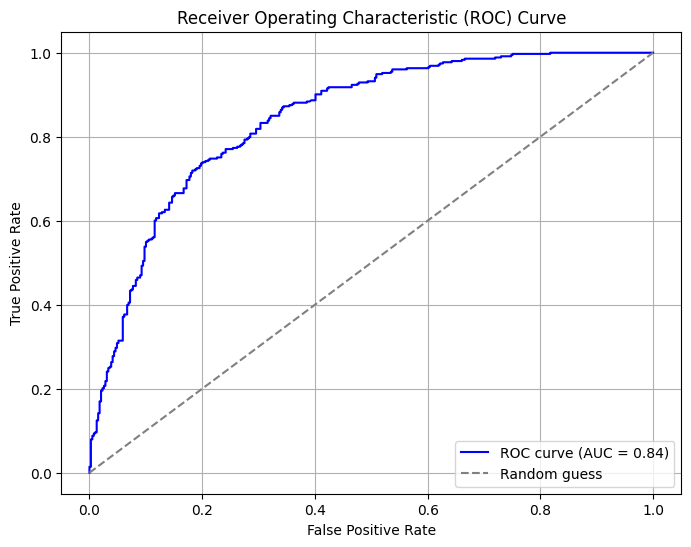

In [201]:
# Veamos la curva ROC y revisemos el valor bajo la curva para medir rendimiento.

# Calcular valores para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
auc_score = roc_auc_score(y_test, y_pred_prob[:, 1])

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Podemos ver que el valor ROC-AUC es 85% lo cual es indicativo de un modelo bueno.

## Entrenamiento iterativo

**🚀 Mejorando el Rendimiento del Modelo**

Para optimizar los resultados obtenidos hasta ahora, proponemos dos estrategias complementarias:

---

**🔹 1. Probar Varios Modelos de Clasificación**
La elección del modelo de machine learning puede tener un impacto significativo en el rendimiento de la predicción de churn. En este sentido, evaluaremos diferentes algoritmos con el objetivo de identificar cuál se ajusta mejor a las características del dataset. Para ello podemos auxiliarnos de las implementaciones de sklearn, lightgbm o xgboost. Los nuevos modelos a considerar son:

- `KNeighborsClassifier`: basado en la proximidad entre puntos de datos.
- `DecisionTreeClassifier`: permite capturar relaciones no lineales de forma sencilla.
- `RandomForestClassifier`: un ensamble de árboles que mejora robustez y generalización.
- `GaussianNB`: basado en la probabilidad condicional bajo la suposición de independencia entre variables.
- `MLPClassifier`: una red neuronal multicapa capaz de modelar relaciones complejas.
- `LGBMClassifier`: un potente algoritmo de boosting basado en árboles, eficiente para grandes datasets.
- `XGBClassifier`: otro método de boosting altamente optimizado y popular en competencias.

Evaluar estos algoritmos nos permitirá comparar métricas como precisión, recall, F1-score y ROC-AUC para determinar cuál ofrece mejores resultados en el problema de churn.

---

**🔹 2. Ajuste de Hiperparámetros (Hyperparameter Tuning)**
Una vez seleccionados los modelos con mejor desempeño, podemos buscar optimizar aún más sus resultados mediante la búsqueda de los hiperparámetros óptimos. Esto se puede realizar utilizando técnicas como:

- **Grid Search (`GridSearchCV`)**: prueba todas las combinaciones posibles de un conjunto definido de valores de hiperparámetros.
- **Randomized Search (`RandomizedSearchCV`)**: selecciona combinaciones aleatorias de hiperparámetros, permitiendo explorar un mayor espacio de búsqueda con menor coste computacional.
- **Optimizadores bayesianos o frameworks avanzados**: como Optuna o Hyperopt, para una búsqueda más eficiente.

El ajuste de hiperparámetros puede mejorar significativamente el rendimiento del modelo al permitirle adaptarse mejor a los datos.

**Para este ejemplo probaremos de forma manual hiperparámetros para LogisticRegression**




In [205]:
modelos = {
    # Modelo abse
    "base logistic reg": LogisticRegression(random_state=42),

    # Modelos a probar
    "knn": KNeighborsClassifier(),
    "decision tree": DecisionTreeClassifier(random_state=42),
    "random forest": RandomForestClassifier(random_state=42),
    "naive bayes": GaussianNB(),
    "neural net": MLPClassifier(random_state=42),
    "lightgbm": LGBMClassifier(random_state=42),
    "xgboost": XGBClassifier(random_state=42),

    # Prueba con hiperparámetros diferentes
    "logistic reg c=0.01": LogisticRegression(random_state=42, C=0.01),
    "knn n=10": KNeighborsClassifier(n_neighbors=10),
}

resultados = []

for nombre, modelo in modelos.items():

  print(f"Entrenando {modelo.__class__.__name__}...")
  modelo.fit(X_train, y_train)

  y_pred = modelo.predict(X_test)
  y_pred_prob = modelo.predict_proba(X_test)

  # calculando métricas y guardando el resultado
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  fpr = fp / (fp + tn)
  tpr = fn / (fn + tp)

  resultados.append(pd.Series({
      "Prueba": nombre,
      "Modelo": modelo.__class__.__name__,
      "Accuracy Train": accuracy_score(y_train, modelo.predict(X_train)), # train acc
      "Accuracy Test": accuracy_score(y_test, y_pred), # test acc
      "Precision": precision_score(y_test, y_pred),
      "Recall": recall_score(y_test, y_pred),
      "F1 Score": f1_score(y_test, y_pred),
      "ROC AUC": roc_auc_score(y_test, y_pred_prob[:, 1]),
      "FPR": fpr,
      "TPR": tpr,
  }))

Entrenando LogisticRegression...
Entrenando KNeighborsClassifier...
Entrenando DecisionTreeClassifier...
Entrenando RandomForestClassifier...
Entrenando GaussianNB...
Entrenando MLPClassifier...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Entrenando LGBMClassifier...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1502, number of negative: 1466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 911
[LightGBM] [Info] Number of data points in the train set: 2968, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506065 -> initscore=0.024260
[LightGBM] [Info] Start training from score 0.024260
Entrenando XGBClassifier...
Entrenando LogisticRegression...
Entrenando KNeighborsClassifier...


Comparemos el performance de cada una de las pruebas

In [206]:
# Realizar benchmark de pruebas
df_benchmark = pd.concat(resultados, axis=1).T.sort_values("Accuracy Test", ascending=False)
df_benchmark

,Prueba,Modelo,Accuracy Train,Accuracy Test,Precision,Recall,F1 Score,ROC AUC,FPR,TPR
6,lightgbm,LGBMClassifier,0.924865,0.765499,0.722084,0.824363,0.769841,0.835989,0.287918,0.175637
8,logistic reg c=0.01,LogisticRegression,0.757075,0.761456,0.721106,0.813031,0.764314,0.845857,0.285347,0.186969
4,naive bayes,GaussianNB,0.753032,0.75876,0.716418,0.815864,0.762914,0.831197,0.293059,0.184136
0,base logistic reg,LogisticRegression,0.762129,0.756065,0.710784,0.82153,0.762155,0.84333,0.303342,0.17847
3,random forest,RandomForestClassifier,0.998652,0.756065,0.717172,0.804533,0.758344,0.827997,0.287918,0.195467
7,xgboost,XGBClassifier,0.976752,0.747978,0.7075,0.8017,0.75166,0.818504,0.300771,0.1983
5,neural net,MLPClassifier,0.854447,0.731806,0.683333,0.813031,0.742561,0.80699,0.341902,0.186969
9,knn n=10,KNeighborsClassifier,0.786051,0.726415,0.692308,0.764873,0.726783,0.800738,0.308483,0.235127
1,knn,KNeighborsClassifier,0.805256,0.703504,0.662592,0.767705,0.711286,0.766413,0.354756,0.232295
2,decision tree,DecisionTreeClassifier,0.998652,0.681941,0.655172,0.699717,0.676712,0.682934,0.33419,0.300283


**Hallazgos del Benchmark de Modelos**

- El modelo **LGBClassifier** (Prueba 6) obtuvo el mayor **Accuracy Test** (0.765499) y un buen equilibrio en **F1 Score** (0.769841) y **ROC AUC** (0.835989), siendo uno de los mejores desempeños generales.
- El **RandomForestClassifier** (Prueba 3) y **DecisionTreeClassifier** (Prueba 2) mostraron un **Accuracy Train** muy alto (0.998652), pero su **Accuracy Test** fue menor, sugiriendo posible sobreajuste.
- El **MLPClassifier** (Prueba 5) y **KNeighborsClassifier** (Pruebas 1 y 9) tuvieron un rendimiento más bajo en **Accuracy Test**, con valores entre 0.703504 y 0.731806.
- La tasa de **FPR** (False Positive Rate) varía significativamente, con valores más altos en modelos como **MLPClassifier** (0.341902) y **KNeighborsClassifier** (0.354756), indicando más falsos positivos.
- La tasa de **TPR** (True Positive Rate) es relativamente baja en general, con el **LGBClassifier** mostrando un valor decente (0.175637).

**Conclusión**

El **LGBClassifier** parece ser el modelo más robusto según los resultados, con un buen equilibrio entre precisión, recall y AUC. Se recomienda revisar las razones de las decisiones del modelo ya que parece haber sobreajustado debido a la diferencia entre train accuracy y testing.

In [208]:
best_model = modelos["lightgbm"]

## Exportación

In [209]:
# Una vez decidimos cuál es el mejor modelo, guardamos los archivos resultantes del proceso de entrenamiento
with open("preprocessor.pkl", "wb") as f:
  pickle.dump(preprocessor, f)
with open("vectorizer.pkl", "wb") as f:
  pickle.dump(vectorizer, f)
with open("model.pkl", "wb") as f:
  pickle.dump(best_model, f)

## Explicabilidad

**Uso de Feature Importances de LightGBM para Explicar Decisiones**

A partir de ahora, utilizaremos los **feature importances** generados por el modelo LightGBM (LGBClassifier) para analizar y explicar qué características o variables tienen mayor influencia en las decisiones del modelo. Este enfoque nos permitirá:

- Identificar las variables más relevantes que impactan las predicciones.
- Comprender mejor el comportamiento del modelo y sus patrones de decisión.
- Proporcionar una base sólida para interpretaciones y ajustes futuros.

Los feature importances de LightGBM se calculan según la contribución de cada característica al reducir la impureza (como el error de ganancia) en los nodos del árbol durante el entrenamiento. Esto nos dará una visión clara de qué factores son determinantes en el contexto de nuestro problema.

A continuación, se presentarán los resultados de los feature importances y su análisis para guiar las interpretaciones.

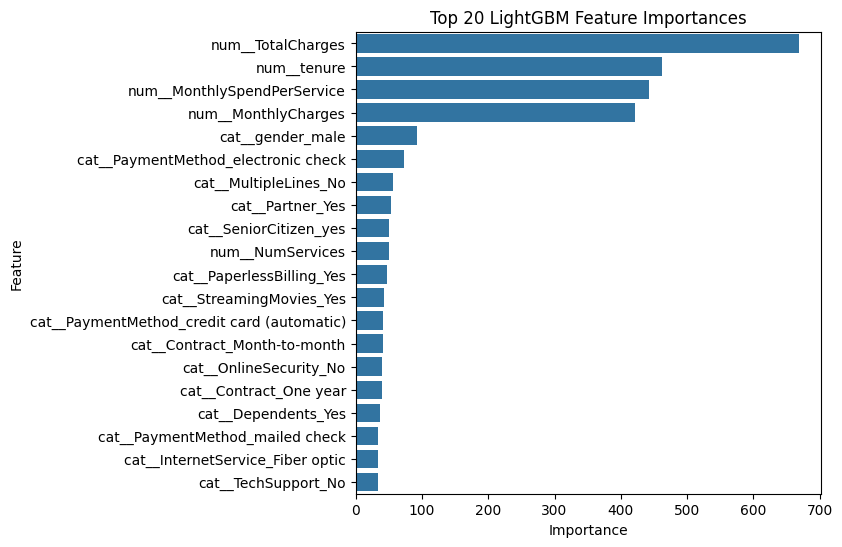

In [215]:
# table with lighgbm feature importances
# OJO, este proceso depende del modelo, el que se muestra a continuación solo funciona para lightgbm
best_model
feature_importance = pd.DataFrame(best_model.feature_importances_, index=X_train.columns, columns=["importance"]).sort_values("importance", ascending=False)

# graficar top 20 features
top_n = 20
plt.figure(figsize=(6, 6))
sns.barplot(x="importance", y=feature_importance.head(top_n).index, data=feature_importance.head(top_n), orient="h")
plt.title(f"Top {top_n} LightGBM Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

**Hallazgos de la Importancia de los Features en LightGBM**

El gráfico presenta las 20 características más importantes según el modelo LightGBM, con sus respectivas importancias. A continuación, se detallan los hallazgos:

**Características Más Influyentes**
- **TotalCharges**: La característica más importante con un valor cercano a 700, indicando que el cargo mensual total tiene un impacto significativo en las decisiones del modelo.
- **tenure**: Con una importancia cercana a 500, sugiere que la duración del cliente es un factor clave en las predicciones.
- **MonthlySpendPerService**: Importancia alrededor de 400, destacando el gasto mensual por servicio como un predictor relevante.
- **MonthlyCharges**: Con un valor cercano a 400, los cargos mensuales totales también juegan un papel importante.

**Características Categóricas Relevantes**
- **gender_male**: Importancia moderada (alrededor de 200), indicando que el género masculino tiene cierta influencia.
- **PaymentMethod_electronic check**: Importancia alrededor de 150, sugiriendo que este método de pago afecta las decisiones.

**Características de Menor Importancia**
- **PaymentMethod_mailed check**, **InternetService_Fiber optic**, y **TechSupport_No**: Estas características tienen importancias cercanas a 0-50, indicando un impacto mínimo en las decisiones del modelo.

**Observaciones Generales**
- Las variables numéricas (**TotalCharges**, **tenure**, **MonthlySpendPerService**, **MonthlyCharges**) dominan la importancia, sugiriendo que los aspectos financieros y la duración son determinantes.
- Entre las categóricas, las relacionadas con métodos de pago, estado demográfico y servicios adicionales tienen un impacto variable, pero generalmente menor comparado con las numéricas.
- La baja importancia de **TechSupport_No** y **InternetService_Fiber optic** podría indicar que estas características no son tan discriminatorias en este conjunto de datos.

**Conclusión**

El modelo LightGBM prioriza variables financieras y de duración del cliente. Se recomienda explorar más a fondo las relaciones entre **TotalCharges** y **tenure** para optimizar las predicciones, mientras se considera un análisis adicional de las características categóricas de menor importancia.